                                                                                           Done by Squad McCarthy: 
                                                        Carlota del Cacho, Gaspar Martínez, Oksana Palej y Javier Requena


# Final Project - Data Preparation - El Bitcoin

En este proyecto vamos predecir el precio del Bitcoin del día siguiente.


<img src="https://www.cronista.com/files/image/427/427818/61f4c0f7ed4e4.jpg" width="300"/>


El proyecto se divide en dos partes y dos notebooks con objetivos diferentes:

1. **La preparación de los datos:** Leer, corregir, entender y generar datos sintéticos para ampliar el conjunto de datos.
2. **Predicción de datos:**  Se entrenará nuetro modelo predictivo, proporcionaremos métricas de ML y se explicarán los resultados junto con las conclusiones del proyecto.

## Exercise 1 - Data Preparation

Descargamos los datos en bruto diarios del sitio web de Yahoo Finanzas en https://pypi.org/project/yfinance/. 

Hay que tener en cuenta que el Bitcoin trabaja todos los días, incluidos fin de semanas y vacaciones.

In [23]:
# !pip install yfinance

In [24]:
# !pip install nasdaq-data-link

In [93]:
# Importamos librerias

import yfinance as yf
import pandas as pd
import numpy as np
from scipy import stats
import quandl
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
import math
from datetime import datetime

Ahora usamos la librería yfinance para obtener datos históricos de Bitcoin (BTC-USD). Posteriormente, eliminaremos las columnas 'Dividends' y 'Stock Splits' del DataFrame hist_bitcoin, pues, aparte de contener únicamente valores nulos, no tienen sentido en en contexto del Bitcoin. 

In [28]:
bitcoin = yf.Ticker('BTC-USD')
hist_bitcoin = bitcoin.history(period="1y", interval="1d")
hist_bitcoin

Open          High           Low  \
Date                                                                  
2022-09-27 00:00:00+00:00  19221.839844  20338.455078  18915.667969   
2022-09-28 00:00:00+00:00  19104.621094  19688.343750  18553.296875   
2022-09-29 00:00:00+00:00  19427.779297  19589.265625  18924.353516   
2022-09-30 00:00:00+00:00  19573.431641  20109.849609  19265.662109   
2022-10-01 00:00:00+00:00  19431.105469  19471.154297  19231.082031   
...                                 ...           ...           ...   
2023-09-23 00:00:00+00:00  26578.556641  26634.185547  26520.519531   
2023-09-24 00:00:00+00:00  26579.373047  26716.058594  26221.050781   
2023-09-25 00:00:00+00:00  26253.775391  26421.507812  26011.468750   
2023-09-26 00:00:00+00:00  26294.757812  26389.884766  26090.712891   
2023-09-27 00:00:00+00:00  26219.730469  26271.017578  26205.367188   

                                  Close       Volume  Dividends  Stock Splits  
Date                                                                           
2022-09-27 00:00:00+00:00  19110.546875  58571439619        0.0           0.0  
2022-09-28 00:00:00+00:00  19426.720703  53071298734        0.0           0.0  
2022-09-29 00:00:00+00:00  19573.050781  41037843771        0.0           0.0  
2022-09-30 00:00:00+00:00  19431.789062  43975248085        0.0           0.0  
2022-10-01 00:00:00+00:00  19312.095703  18719537670        0.0           0.0  
...                                 ...          ...        ...           ...  
2023-09-23 00:00:00+00:00  26579.390625   7404700301        0.0           0.0  
2023-09-24 00:00:00+00:00  26256.826172   8192867686        0.0           0.0  
2023-09-25 00:00:00+00:00  26298.480469  11997833257        0.0           0.0  
2023-09-26 00:00:00+00:00  26217.250000   9985498161        0.0           0.0  
2023-09-27 00:00:00+00:00  26244.328125   7237851648        0.0           0.0  

[366 rows x 7 columns]

In [29]:
hist_bitcoin.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2022-09-27 00:00:00+00:00 to 2023-09-27 00:00:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          366 non-null    float64
 1   High          366 non-null    float64
 2   Low           366 non-null    float64
 3   Close         366 non-null    float64
 4   Volume        366 non-null    int64  
 5   Dividends     366 non-null    float64
 6   Stock Splits  366 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 22.9 KB


In [30]:
hist_bitcoin.describe()

Open          High           Low         Close        Volume  \
count    366.000000    366.000000    366.000000    366.000000  3.660000e+02   
mean   24170.478457  24537.047499  23826.461935  24190.132103  2.125343e+10   
std     4684.611652   4750.776336   4624.887789   4680.194656  1.311184e+10   
min    15782.300781  16253.047852  15599.046875  15787.284180  5.481314e+09   
25%    19695.322266  20344.914062  19360.893066  19921.041504  1.283394e+10   
50%    25861.751953  26130.688477  25511.282227  25882.238281  1.775849e+10   
75%    28067.094238  28508.125000  27443.696777  28075.270020  2.660573e+10   
max    31474.720703  31814.515625  30659.355469  31476.048828  1.189925e+11   

       Dividends  Stock Splits  
count      366.0         366.0  
mean         0.0           0.0  
std          0.0           0.0  
min          0.0           0.0  
25%          0.0           0.0  
50%          0.0           0.0  
75%          0.0           0.0  
max          0.0           0.0

In [31]:
hist_bitcoin.drop(columns=['Dividends','Stock Splits'], inplace=True)

Aquí mostramos los puntos de datos y sus características (EDA) y generamos datos sintéticos para ampliar el conjunto de datos. Para comenzar, calcularemos la SMA (Simple Moving Average) y la volatilidad (σ móvil) de 30 días asociada el precio de cierre (Close):

In [32]:
close_bit = hist_bitcoin["Close"].to_frame()
close_bit["SMA30"] = hist_bitcoin['Close'].rolling(30).mean()
close_bit["STD"] = hist_bitcoin['Close'].rolling(30).std()

In [33]:
close_bit.dropna(inplace=True)

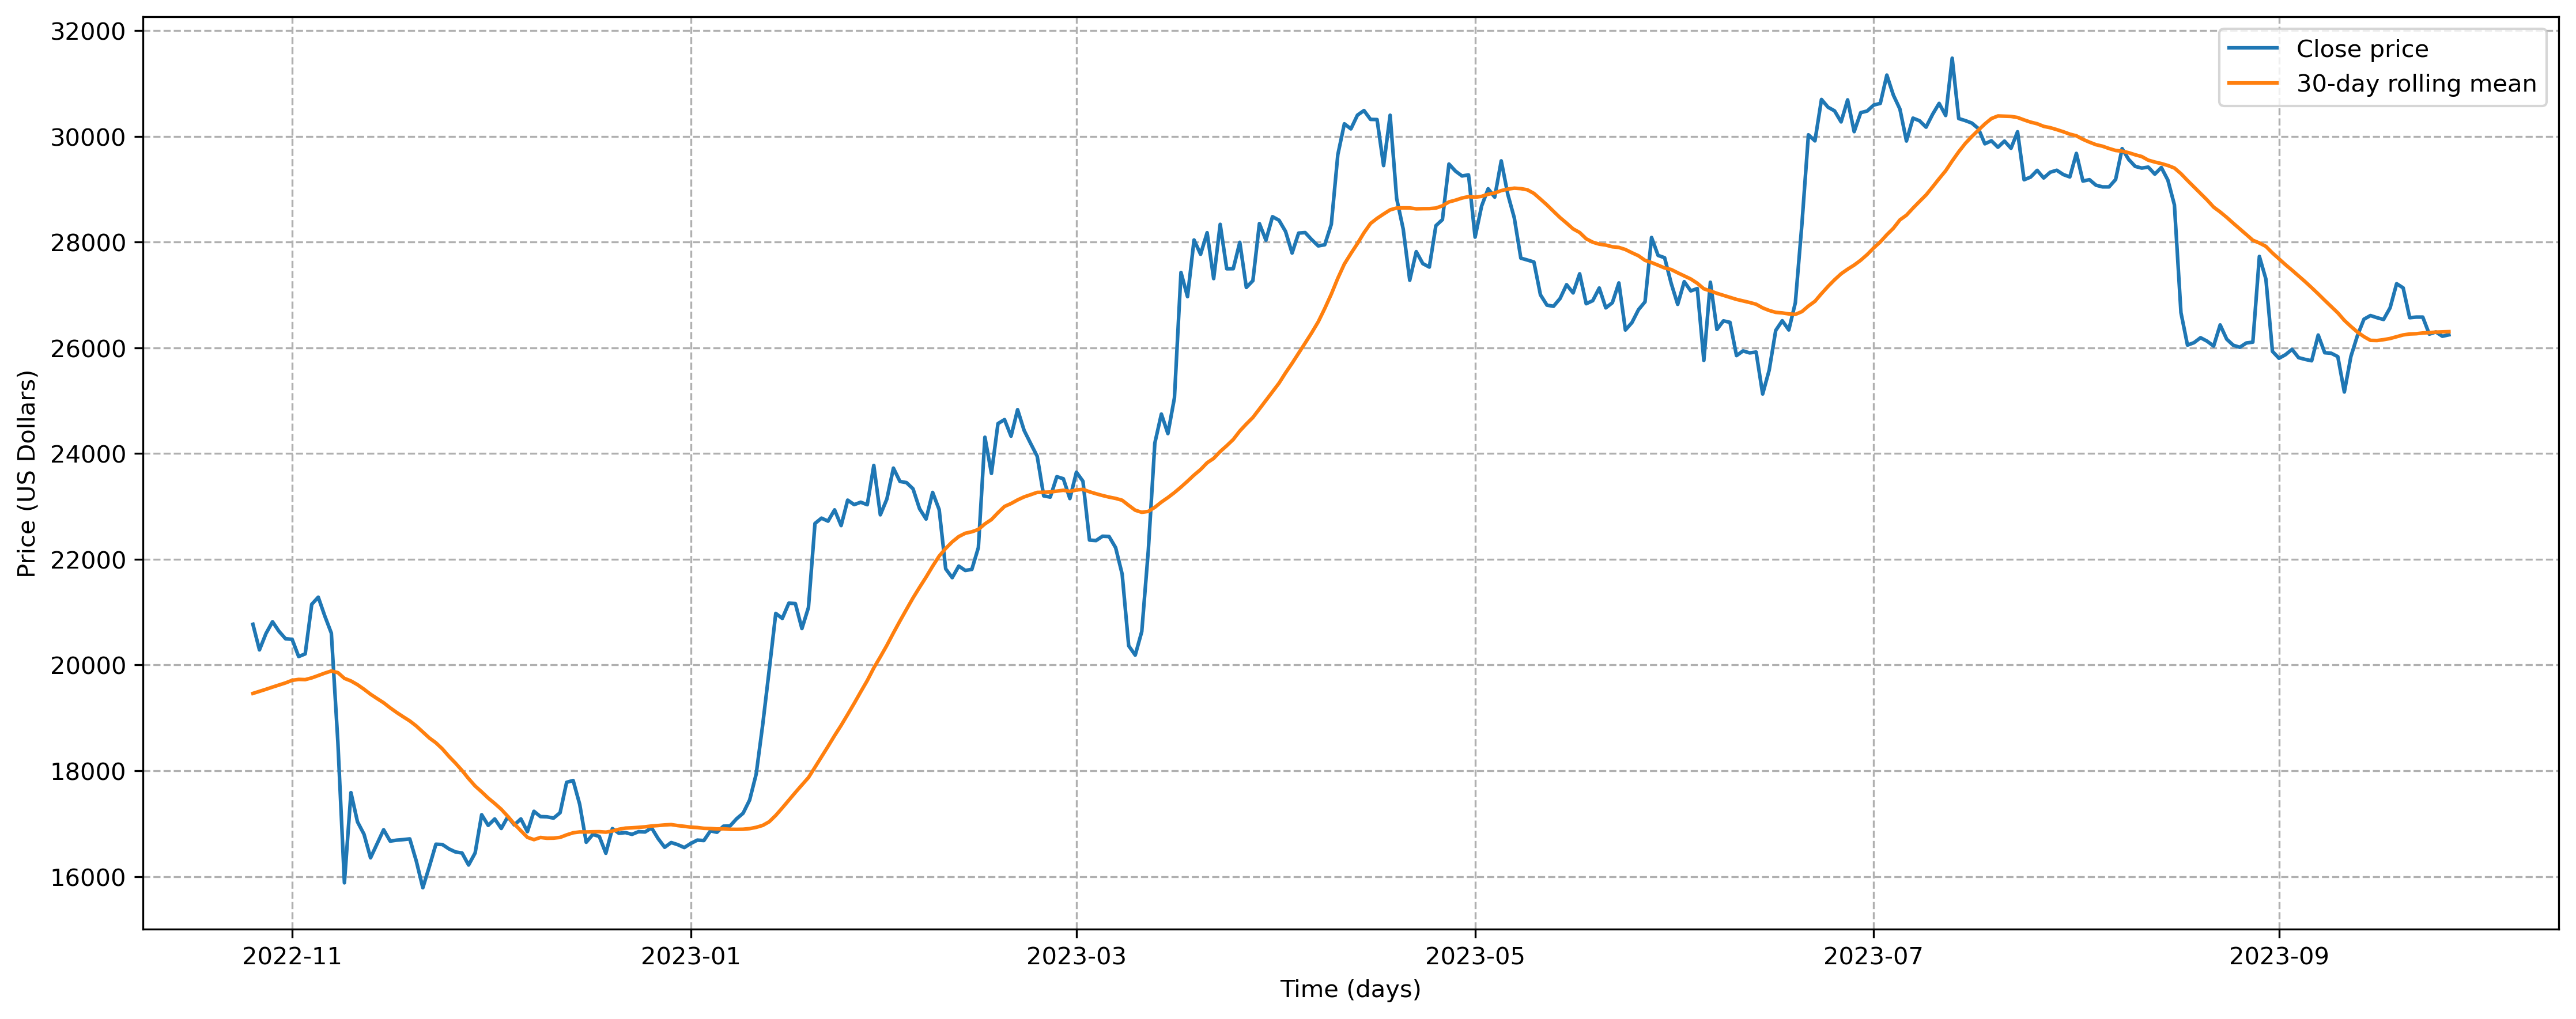

In [34]:
fig, ax = plt.subplots(figsize=[15,8])
ax.plot(close_bit["Close"], label="Close price")
ax.plot(close_bit["SMA30"], label="30-day rolling mean")

ax.set_xlabel("Time (days)")
ax.set_ylabel("Price (US Dollars)")
ax.grid(linestyle="dashed")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

En este gráfico se muestra la evolución de los precios de cierre de Bitcoin junto con su media móvil simple de 30 períodos, lo que puede proporcionar una visualización útil para analizar tendencias y patrones en los datos de precios.

Como podemos observar en el gráfico de arriba, los precios van subiendo a medida que el tiempo pasa, esto significa que la tendencia de los precios es alcista en ese período de tiempo. En otras palabras, los precios están experimentando un movimiento ascendente, patrón que se puede observar tanto en los datos en crudo como en la media móvil de 30 días calculada.


### Por otra parte, 

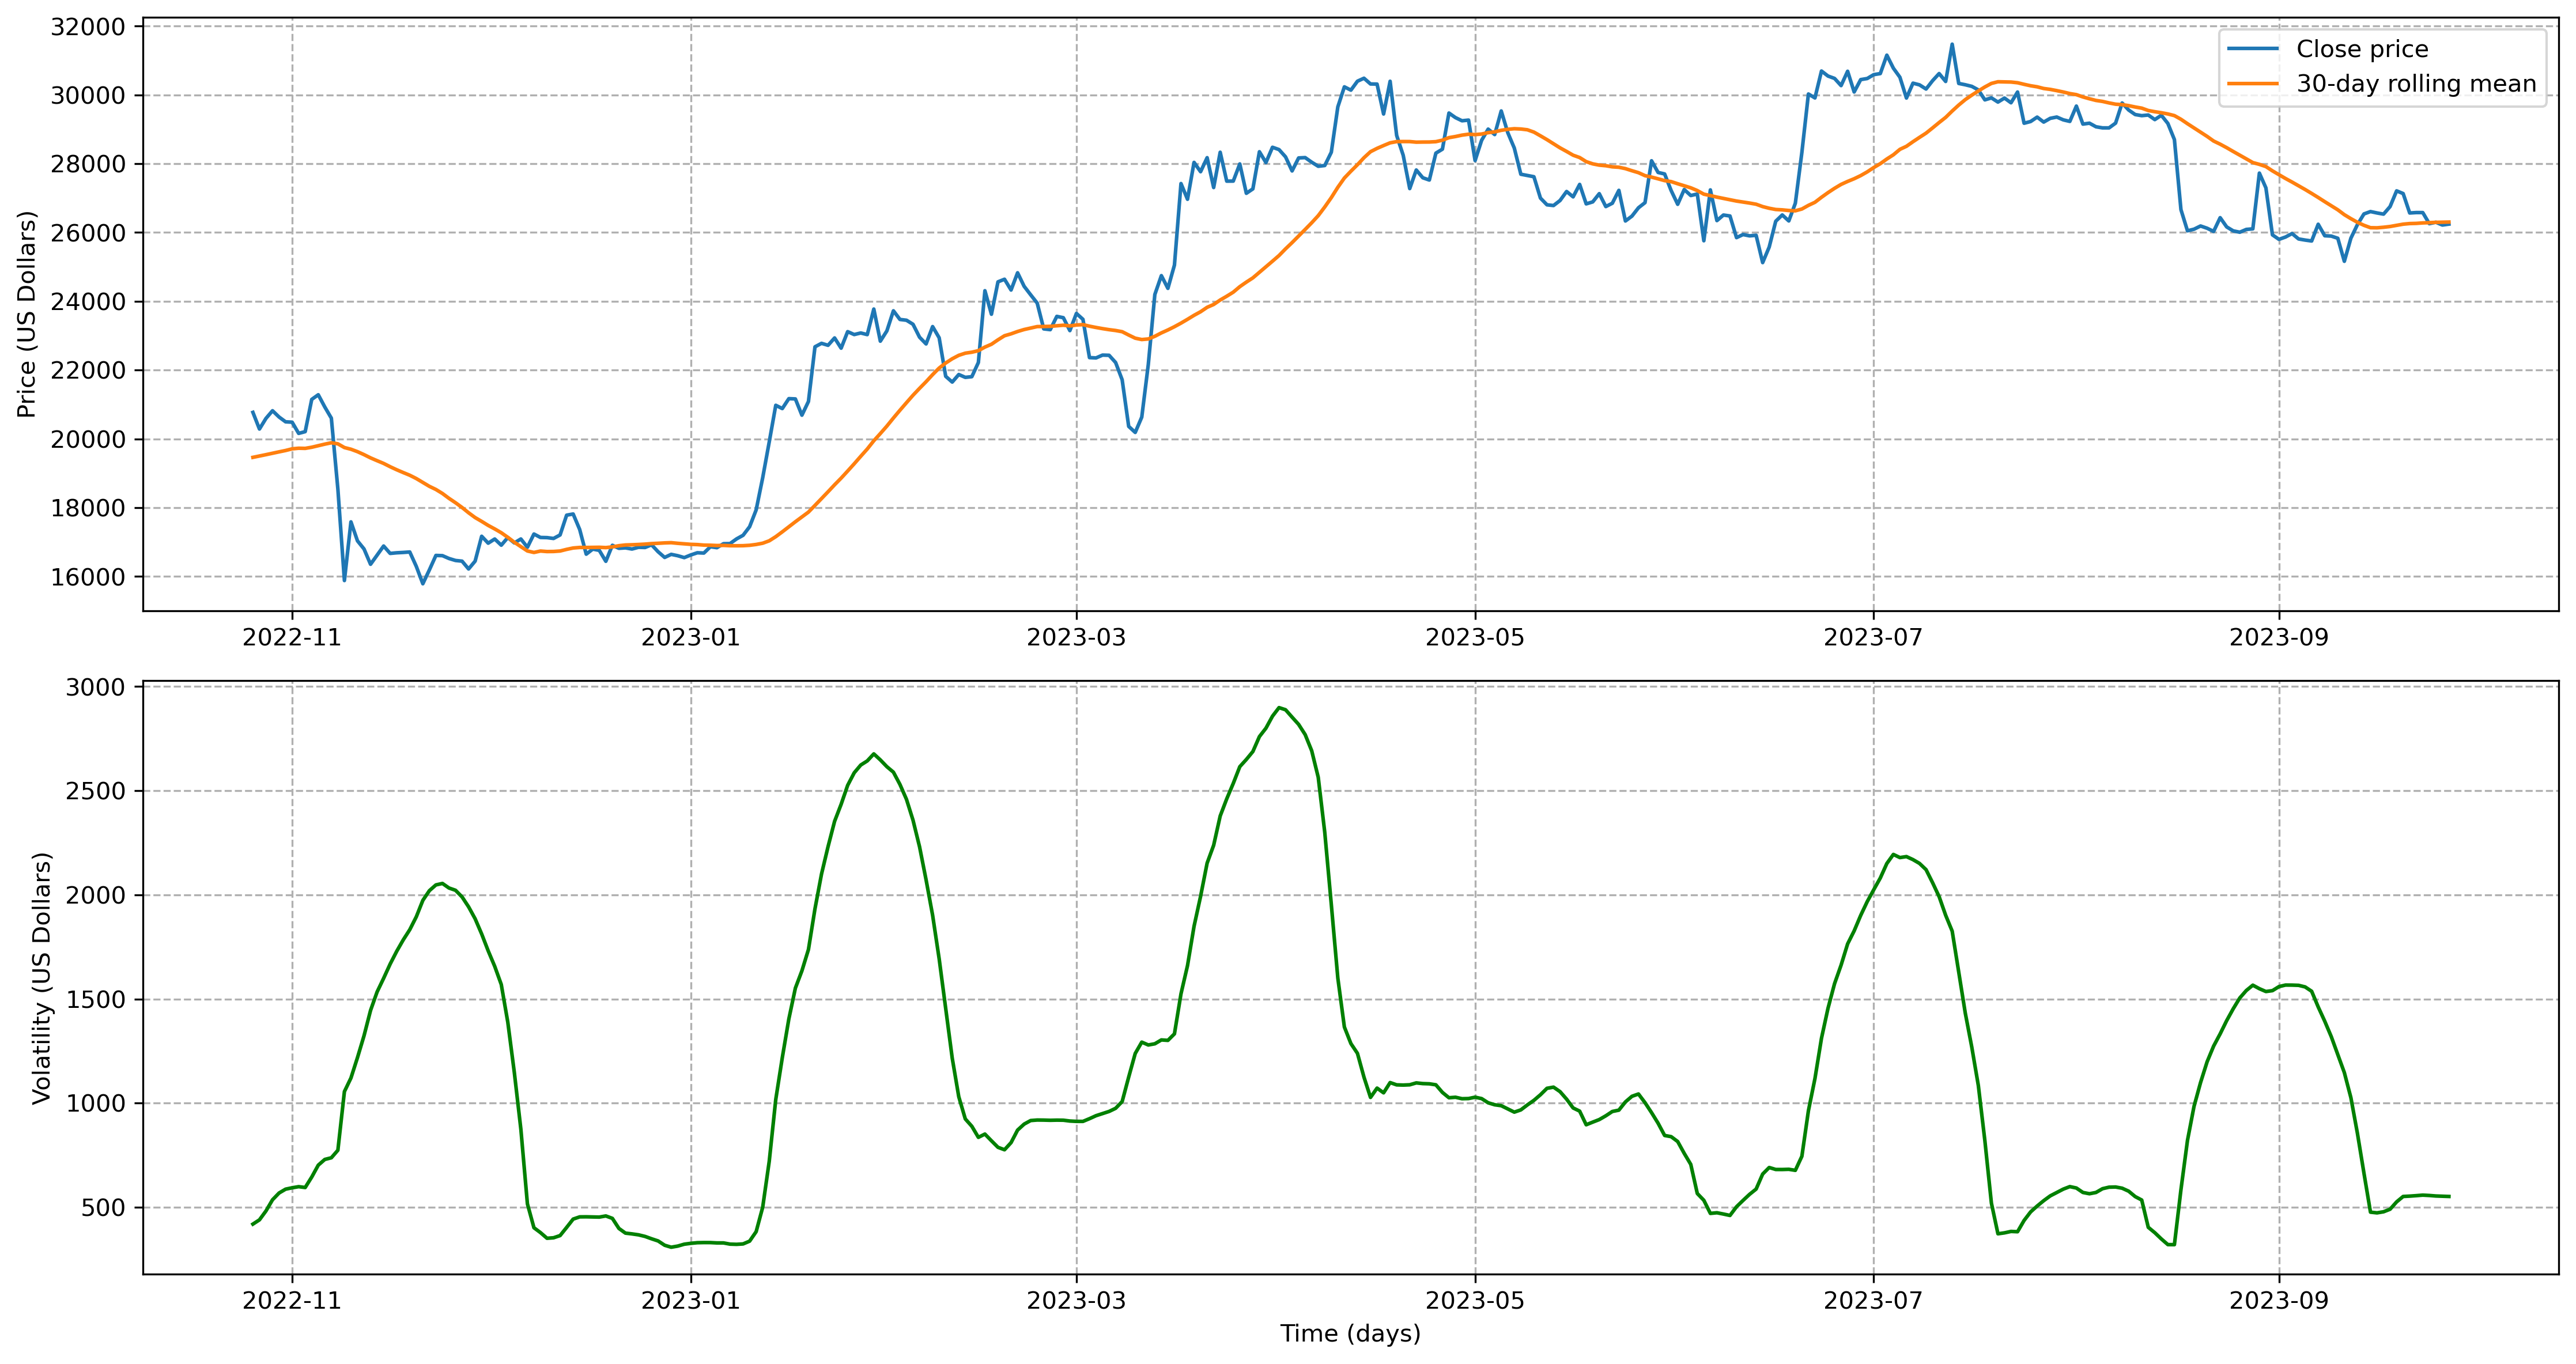

In [38]:
fig, ax = plt.subplots(2, 1, figsize=[15,10])
ax[0].plot(close_bit["Close"], label="Close price")
ax[0].plot(close_bit["SMA30"], label="30-day rolling mean")
ax[0].set_ylabel("Price (US Dollars)")
ax[0].grid(linestyle="dashed")
ax[0].legend(loc="best")

ax[1].plot(close_bit["STD30"], label="30-day rolling volatility", c="green")
ax[1].set_ylabel("Volatility (US Dollars)")
ax[1].grid(linestyle="dashed")
plt.xlabel("Time (days)")

plt.tight_layout()
plt.show()

En esta gráfica que vemos arriba hemos observado cómo varía la desviación estándar móvil de los precios de cierre de Bitcoin a lo largo del tiempo. La desviación estándar móvil es una medida de la volatilidad en los precios. Como podemos ver, la desviación estándar móvil aumenta en algunos momentos temporales, esto sugiere que la volatilidad en los precios está aumentando en ese período de tiempo, cosa que el lógica porque coinciden con los períodos de grandes cambios en el precio. 


### 2. GSPC


Utilizamos YFinance para descargar el índice Standard & Poor's 500 (su símbolo o ticker es "^GSPC").  La Bolsa "tradicional" funciona diariamente de lunes a viernes. Los fines de semana y festivos permanecerá cerrada. El precio del bitcoin puede correlacionarse (o no) con el Índice Standard & Poor's 500 y nos dará cierto contexto de mercado. 

In [40]:
stand = yf.Ticker('^GSPC')
hist_stand = stand.history(period="1y", interval="1d")
hist_stand.drop(['Dividends','Stock Splits'],axis=1, inplace=True)
hist_stand

Open         High          Low        Close  \
Date                                                                            
2022-09-27 00:00:00-04:00  3686.439941  3717.530029  3623.290039  3647.290039   
2022-09-28 00:00:00-04:00  3651.939941  3736.739990  3640.610107  3719.040039   
2022-09-29 00:00:00-04:00  3687.010010  3687.010010  3610.399902  3640.469971   
2022-09-30 00:00:00-04:00  3633.479980  3671.439941  3584.129883  3585.620117   
2022-10-03 00:00:00-04:00  3609.780029  3698.350098  3604.929932  3678.429932   
...                                ...          ...          ...          ...   
2023-09-20 00:00:00-04:00  4452.810059  4461.029785  4401.379883  4402.200195   
2023-09-21 00:00:00-04:00  4374.359863  4375.700195  4329.169922  4330.000000   
2023-09-22 00:00:00-04:00  4341.740234  4357.399902  4316.490234  4320.060059   
2023-09-25 00:00:00-04:00  4310.620117  4338.509766  4302.700195  4337.439941   
2023-09-26 00:00:00-04:00  4312.879883  4313.009766  4265.979980  4273.529785   

                               Volume  
Date                                   
2022-09-27 00:00:00-04:00  4577740000  
2022-09-28 00:00:00-04:00  4684850000  
2022-09-29 00:00:00-04:00  4681810000  
2022-09-30 00:00:00-04:00  5645360000  
2022-10-03 00:00:00-04:00  4806680000  
...                               ...  
2023-09-20 00:00:00-04:00  3308450000  
2023-09-21 00:00:00-04:00  3662340000  
2023-09-22 00:00:00-04:00  3349570000  
2023-09-25 00:00:00-04:00  3195650000  
2023-09-26 00:00:00-04:00  3472340000  

[251 rows x 5 columns]

Aquí hemos utilizado la biblioteca yfinance para obtener datos históricos del índice S&P 500 para el último año, representado por el símbolo '^GSPC'.

Los datos están listos para su análisis o visualización, al eliminar las columnas de dividendos y divisiones de acciones.


In [41]:
close_sp = hist_stand["Close"].to_frame()
close_sp["SMA30"] = hist_stand['Close'].rolling(30).mean()
close_sp["STD30"] = hist_stand['Close'].rolling(30).std()
close_sp.dropna(inplace=True)

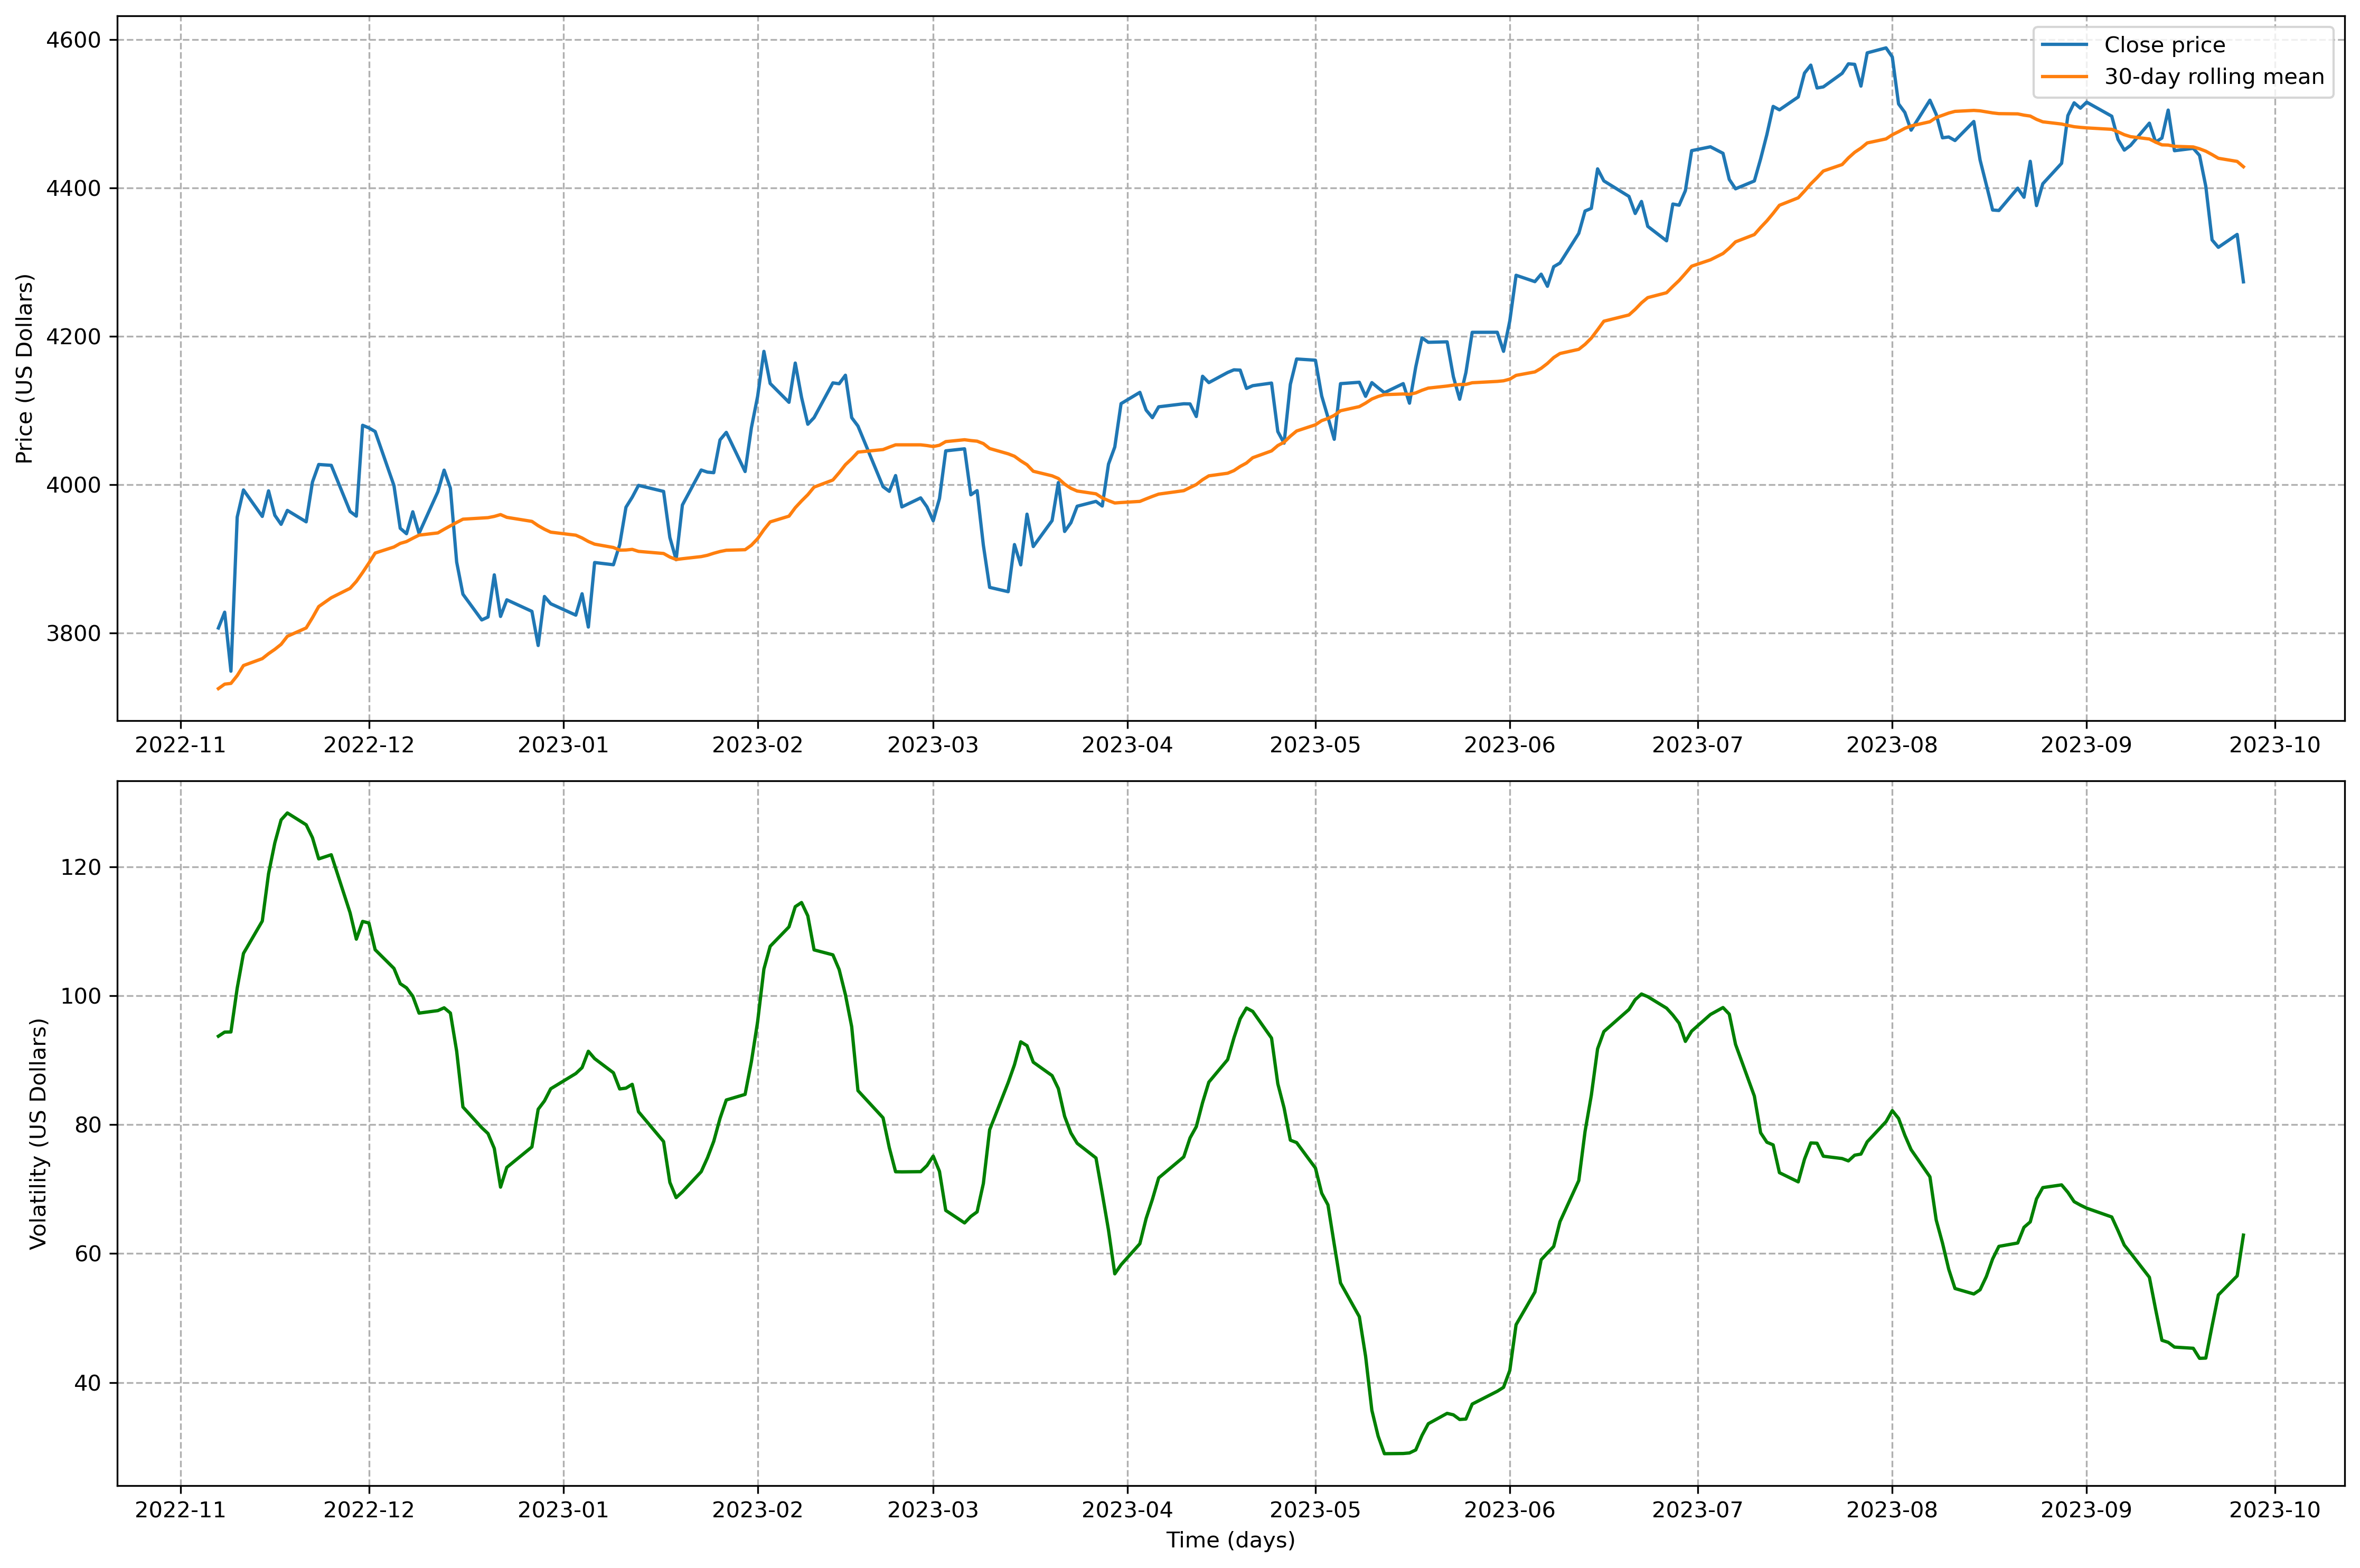

In [43]:
fig, ax = plt.subplots(2, 1, figsize=[15,10])
ax[0].plot(close_sp["Close"], label="Close price")
ax[0].plot(close_sp["SMA30"], label="30-day rolling mean")
ax[0].set_ylabel("Price (US Dollars)")
ax[0].grid(linestyle="dashed")
ax[0].legend(loc="best")

ax[1].plot(close_sp["STD30"], label="30-day rolling volatility", c="green")
ax[1].set_ylabel("Volatility (US Dollars)")
ax[1].grid(linestyle="dashed")
plt.xlabel("Time (days)")

plt.tight_layout()
plt.show()

## 3. LBMA/GOLD

El precio del Bitcoin también puede correlacionarse con el precio de los lingotes de oro. Utilizaremos Quandl (una empresa del NASDAQ) para obtener los datos. Para esto, hemos obtenido la Clave API, y hemos descargado los datos usando el ticker: "LBMA/GOLD".


In [44]:
fecha_actual = datetime.now().date()
fecha_inicio = fecha_actual.replace(year=fecha_actual.year - 1)
fecha_actual_str = fecha_actual.strftime('%Y-%m-%d')
fecha_inicio_str = fecha_inicio.strftime('%Y-%m-%d')

quandl.ApiConfig.api_key = "_K6jjdo5gz3gwR3wdSsW"
gold = quandl.get('LBMA/GOLD', start_date= fecha_inicio_str, end_date= fecha_actual_str)


In [45]:
gold.head()

USD (AM)  USD (PM)  GBP (AM)  GBP (PM)  EURO (AM)  EURO (PM)
Date                                                                    
2022-09-27   1632.60   1634.30   1512.77   1518.59    1696.76    1700.82
2022-09-28   1618.20   1652.15   1517.06   1547.07    1694.74    1721.71
2022-09-29   1646.60   1654.80   1519.15   1507.52    1701.76    1698.98
2022-09-30   1672.75   1671.75   1495.94   1502.40    1703.70    1710.53
2022-10-03   1660.80   1668.40   1482.76   1484.21    1697.84    1705.61

In [46]:
gold.drop(['GBP (AM)','GBP (PM)','EURO (AM)','EURO (PM)'], axis=1, inplace=True)

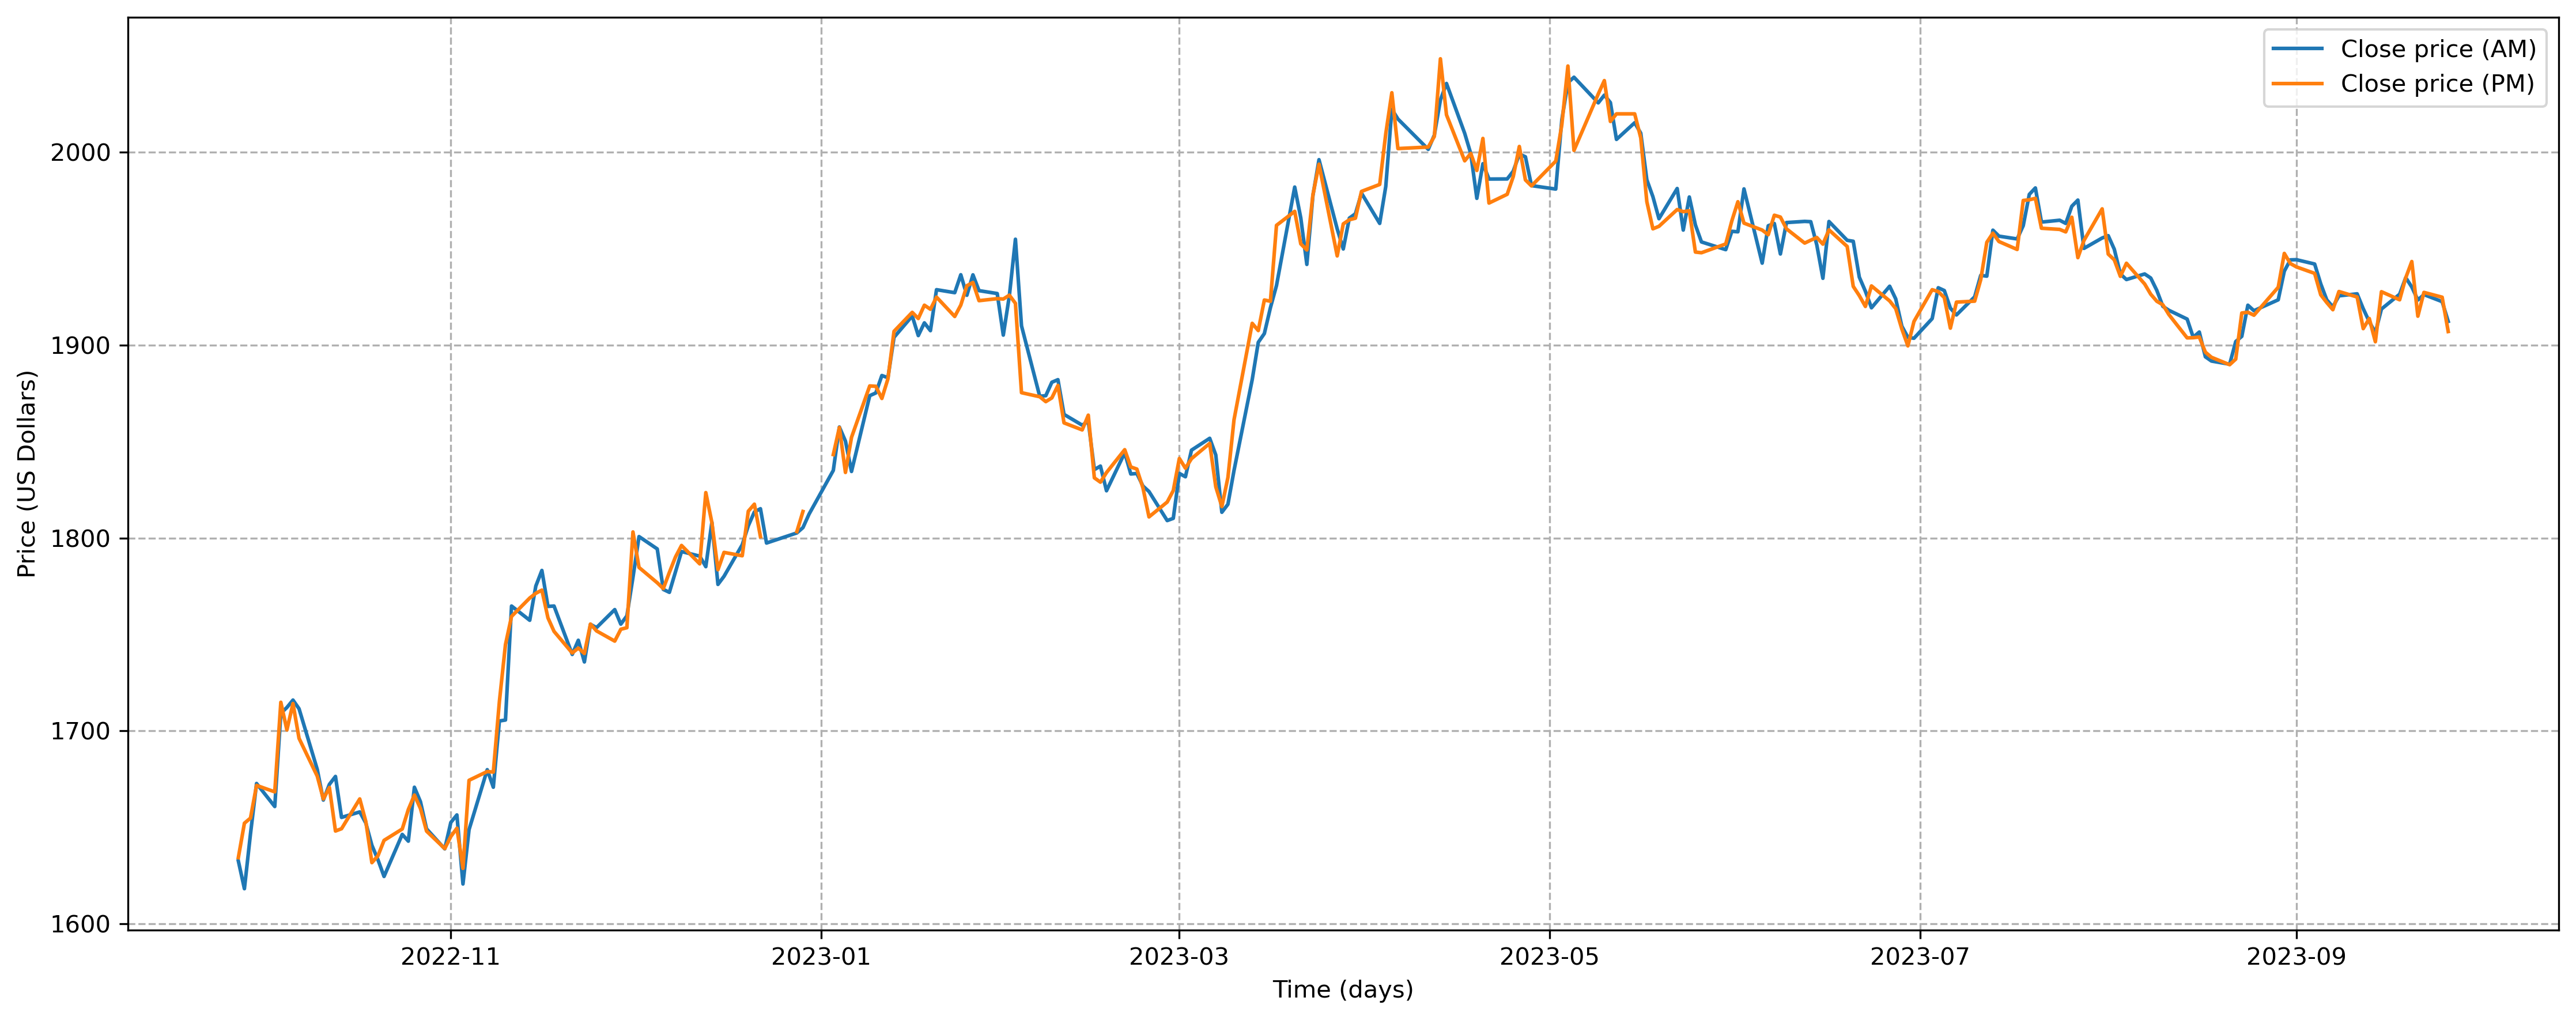

In [47]:
fig, ax = plt.subplots(figsize=[15,8])
ax.plot(gold["USD (AM)"], label="Close price (AM)")
ax.plot(gold["USD (PM)"], label="Close price (PM)")

ax.set_xlabel("Time (days)")
ax.set_ylabel("Price (US Dollars)")
ax.grid(linestyle="dashed")
plt.legend(loc="best")

plt.tight_layout()
plt.show()


Esta gráfica de lineas muestra la evolución del precio del oro en el último año. Esto nos permite visualizar cómo ha variado el precio del oro durante un período de tiempo, desde el 09/2022 al 09/2023.

Vamos a unir todas las tablas de datos en una, a fin de poder tener toda la información en un solo sitio. Para ello, preparamos primero las fechas de los índices:

In [51]:
hist_stand.index = hist_stand.index.date
hist_bitcoin.index = hist_bitcoin.index.date
gold.index = gold.index.date

Usaremos primero `pd.merge()` para unir los precios del Bitcoin con los del S&P500.

In [52]:
data2 = pd.merge(left=hist_bitcoin, right=hist_stand, left_index=True, right_index=True, how='outer', suffixes=["_Bitcoin", "_S&P_500"])

In [53]:
data2.head()

Open_Bitcoin  High_Bitcoin   Low_Bitcoin  Close_Bitcoin  \
2022-09-27  19221.839844  20338.455078  18915.667969   19110.546875   
2022-09-28  19104.621094  19688.343750  18553.296875   19426.720703   
2022-09-29  19427.779297  19589.265625  18924.353516   19573.050781   
2022-09-30  19573.431641  20109.849609  19265.662109   19431.789062   
2022-10-01  19431.105469  19471.154297  19231.082031   19312.095703   

            Volume_Bitcoin  Open_S&P_500  High_S&P_500  Low_S&P_500  \
2022-09-27     58571439619   3686.439941   3717.530029  3623.290039   
2022-09-28     53071298734   3651.939941   3736.739990  3640.610107   
2022-09-29     41037843771   3687.010010   3687.010010  3610.399902   
2022-09-30     43975248085   3633.479980   3671.439941  3584.129883   
2022-10-01     18719537670           NaN           NaN          NaN   

            Close_S&P_500  Volume_S&P_500  
2022-09-27    3647.290039    4.577740e+09  
2022-09-28    3719.040039    4.684850e+09  
2022-09-29    3640.469971    4.681810e+09  
2022-09-30    3585.620117    5.645360e+09  
2022-10-01            NaN             NaN

Para finalizar, concatenamos los precios del oro:

In [54]:
data3 = pd.concat([data2, gold], axis=1)

Lo que nos da el dataframe final:

In [55]:
data3.head()

Open_Bitcoin  High_Bitcoin   Low_Bitcoin  Close_Bitcoin  \
2022-09-27  19221.839844  20338.455078  18915.667969   19110.546875   
2022-09-28  19104.621094  19688.343750  18553.296875   19426.720703   
2022-09-29  19427.779297  19589.265625  18924.353516   19573.050781   
2022-09-30  19573.431641  20109.849609  19265.662109   19431.789062   
2022-10-01  19431.105469  19471.154297  19231.082031   19312.095703   

            Volume_Bitcoin  Open_S&P_500  High_S&P_500  Low_S&P_500  \
2022-09-27     58571439619   3686.439941   3717.530029  3623.290039   
2022-09-28     53071298734   3651.939941   3736.739990  3640.610107   
2022-09-29     41037843771   3687.010010   3687.010010  3610.399902   
2022-09-30     43975248085   3633.479980   3671.439941  3584.129883   
2022-10-01     18719537670           NaN           NaN          NaN   

            Close_S&P_500  Volume_S&P_500  USD (AM)  USD (PM)  
2022-09-27    3647.290039    4.577740e+09   1632.60   1634.30  
2022-09-28    3719.040039    4.684850e+09   1618.20   1652.15  
2022-09-29    3640.469971    4.681810e+09   1646.60   1654.80  
2022-09-30    3585.620117    5.645360e+09   1672.75   1671.75  
2022-10-01            NaN             NaN       NaN       NaN

### 4. Calcula estadísticas básicas sobre los datos:


In [56]:
close_bit = hist_bitcoin["Close"].to_frame()
close_bit["SMA30"] = hist_bitcoin['Close'].rolling(30).mean()
close_bit["STD30"] = hist_bitcoin['Close'].rolling(30).std()
close_bit["Upper_Bollinger"] = close_bit["SMA30"] + 2*close_bit["STD30"]
close_bit["Lower_Bollinger"] = close_bit["SMA30"] - 2*close_bit["STD30"]
close_bit.dropna(inplace=True)

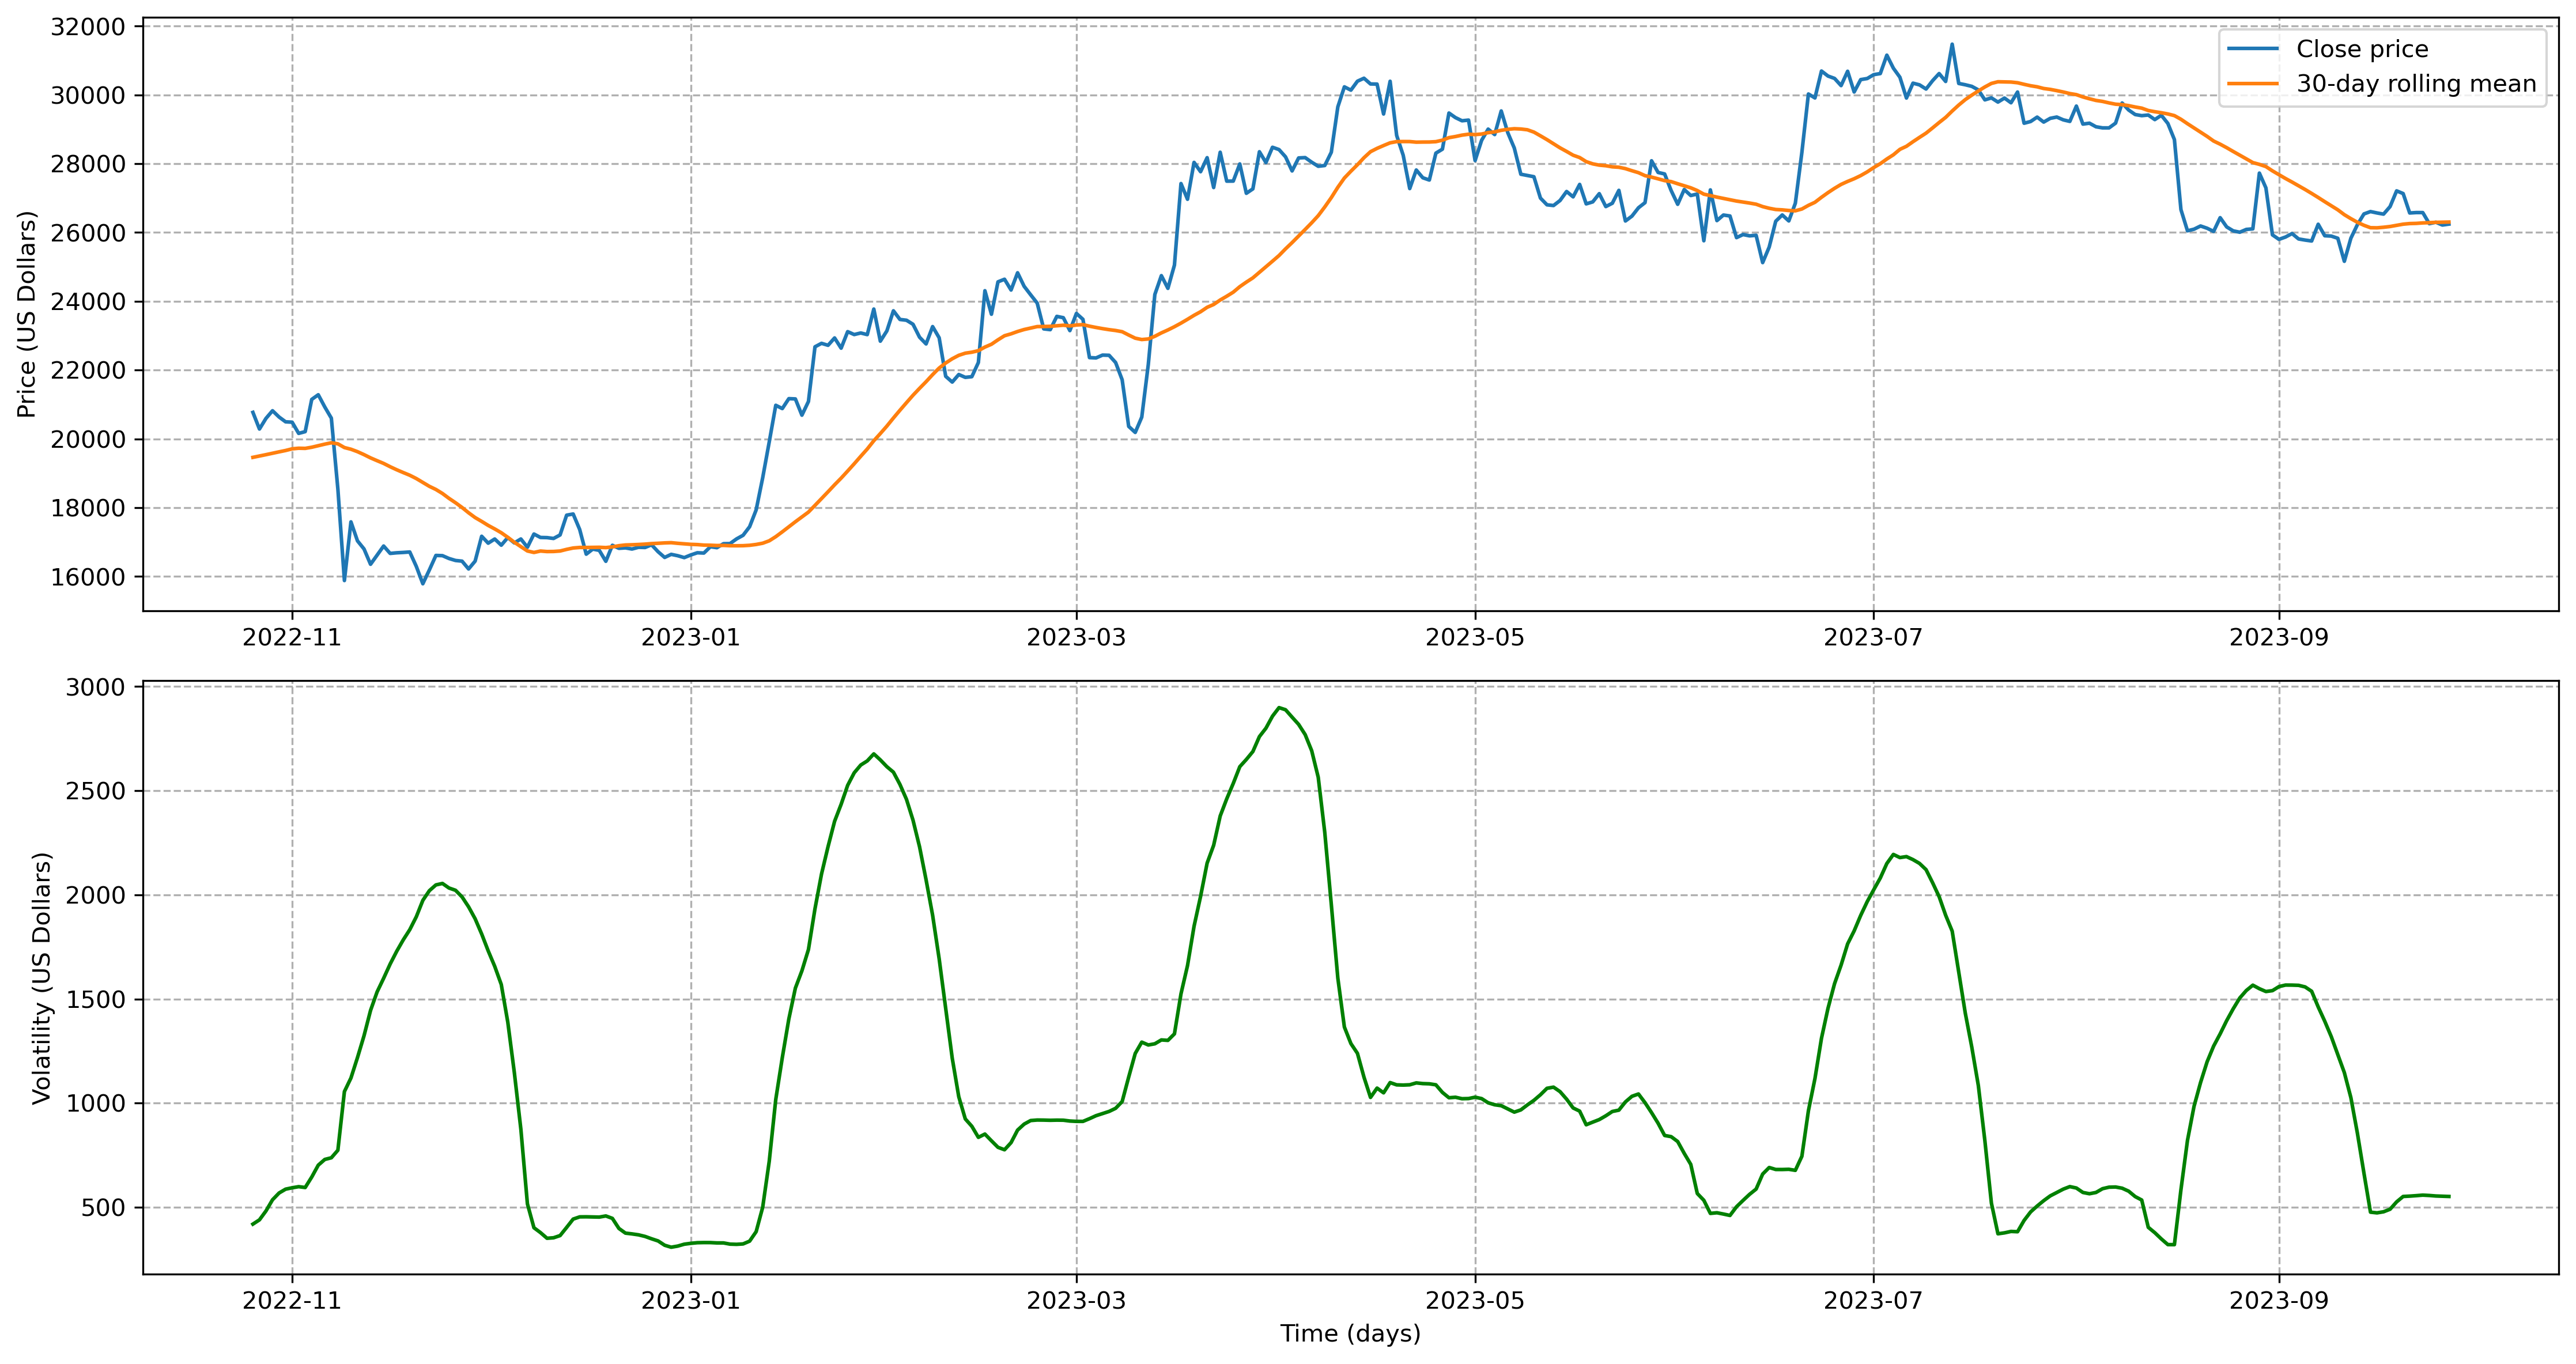

In [59]:
fig, ax = plt.subplots(2, 1, figsize=[15,8])
ax[0].plot(close_bit["Close"], label="Close price")
ax[0].plot(close_bit["SMA30"], label="30-day rolling mean")
ax[0].set_ylabel("Price (US Dollars)")
ax[0].grid(linestyle="dashed")
ax[0].legend(loc="best")

ax[1].plot(close_bit["STD30"], label="30-day rolling volatility", c="green")
ax[1].set_ylabel("Volatility (US Dollars)")
ax[1].grid(linestyle="dashed")
plt.xlabel("Time (days)")

plt.tight_layout()
plt.show()

Estos son dos gráficos con dos subplots apilados verticalmente. El primer subplot muestra los precios de "close" y la media móvil simple de 30 períodos. El segundo subplot muestra la desviación estándar móvil de 30 períodos.
Estos dos gráficos nos permiten analizar la tendencia y la volatilidad de los precios de Bitcoin en función de estos indicadores técnicos, de igual forma, podemos visualizar fácilmente cómo variaciones temporales.

Como podemos ver, en la primera gráfica podemos ver un aumento en la línea que representa los precios de cierre, significa que los precios de cierre de Bitcoin están aumentando con el tiempo. La línea de la Media Móvil Simple (SMA30) suele ser más suave y reacciona más lentamente a los cambios en los precios. Si la línea SMA30 también está subiendo, indica que los precios han estado por encima de su promedio móvil durante el período de tiempo especificado.

Por otra parte, en la segunda gráfica representa la volatilidad en los precios de Bitcoin. El valor en esta gráfica vemos que sube y baja, significa que la volatilidad en los precios está variando durante el período de tiempo considerado. Cuando el valor de la STD30 es alto, indica que los precios de Bitcoin están experimentando cambios significativos y rápidos en un corto período de tiempo, lo que se dice en una mayor volatilidad. Cuando el valor es bajo, indica que los precios están cambiando de manera más gradual y la volatilidad es menor.

#### Otro ejemplo:

Por otro lado, hemos creado otro gráfico de líneas que muestra los precios de cierre de Bitcoin junto con su media móvil simple de 30 períodos y las bandas de Bollinger superior e inferior en el mismo subplot. 

**Nota**: Las bandas de Bollinger pueden ayudar a identificar posibles niveles de sobrecompra y sobreventa en el mercado, mientras que la media móvil simple suaviza los movimientos de precios y facilita la identificación de tendencias. 

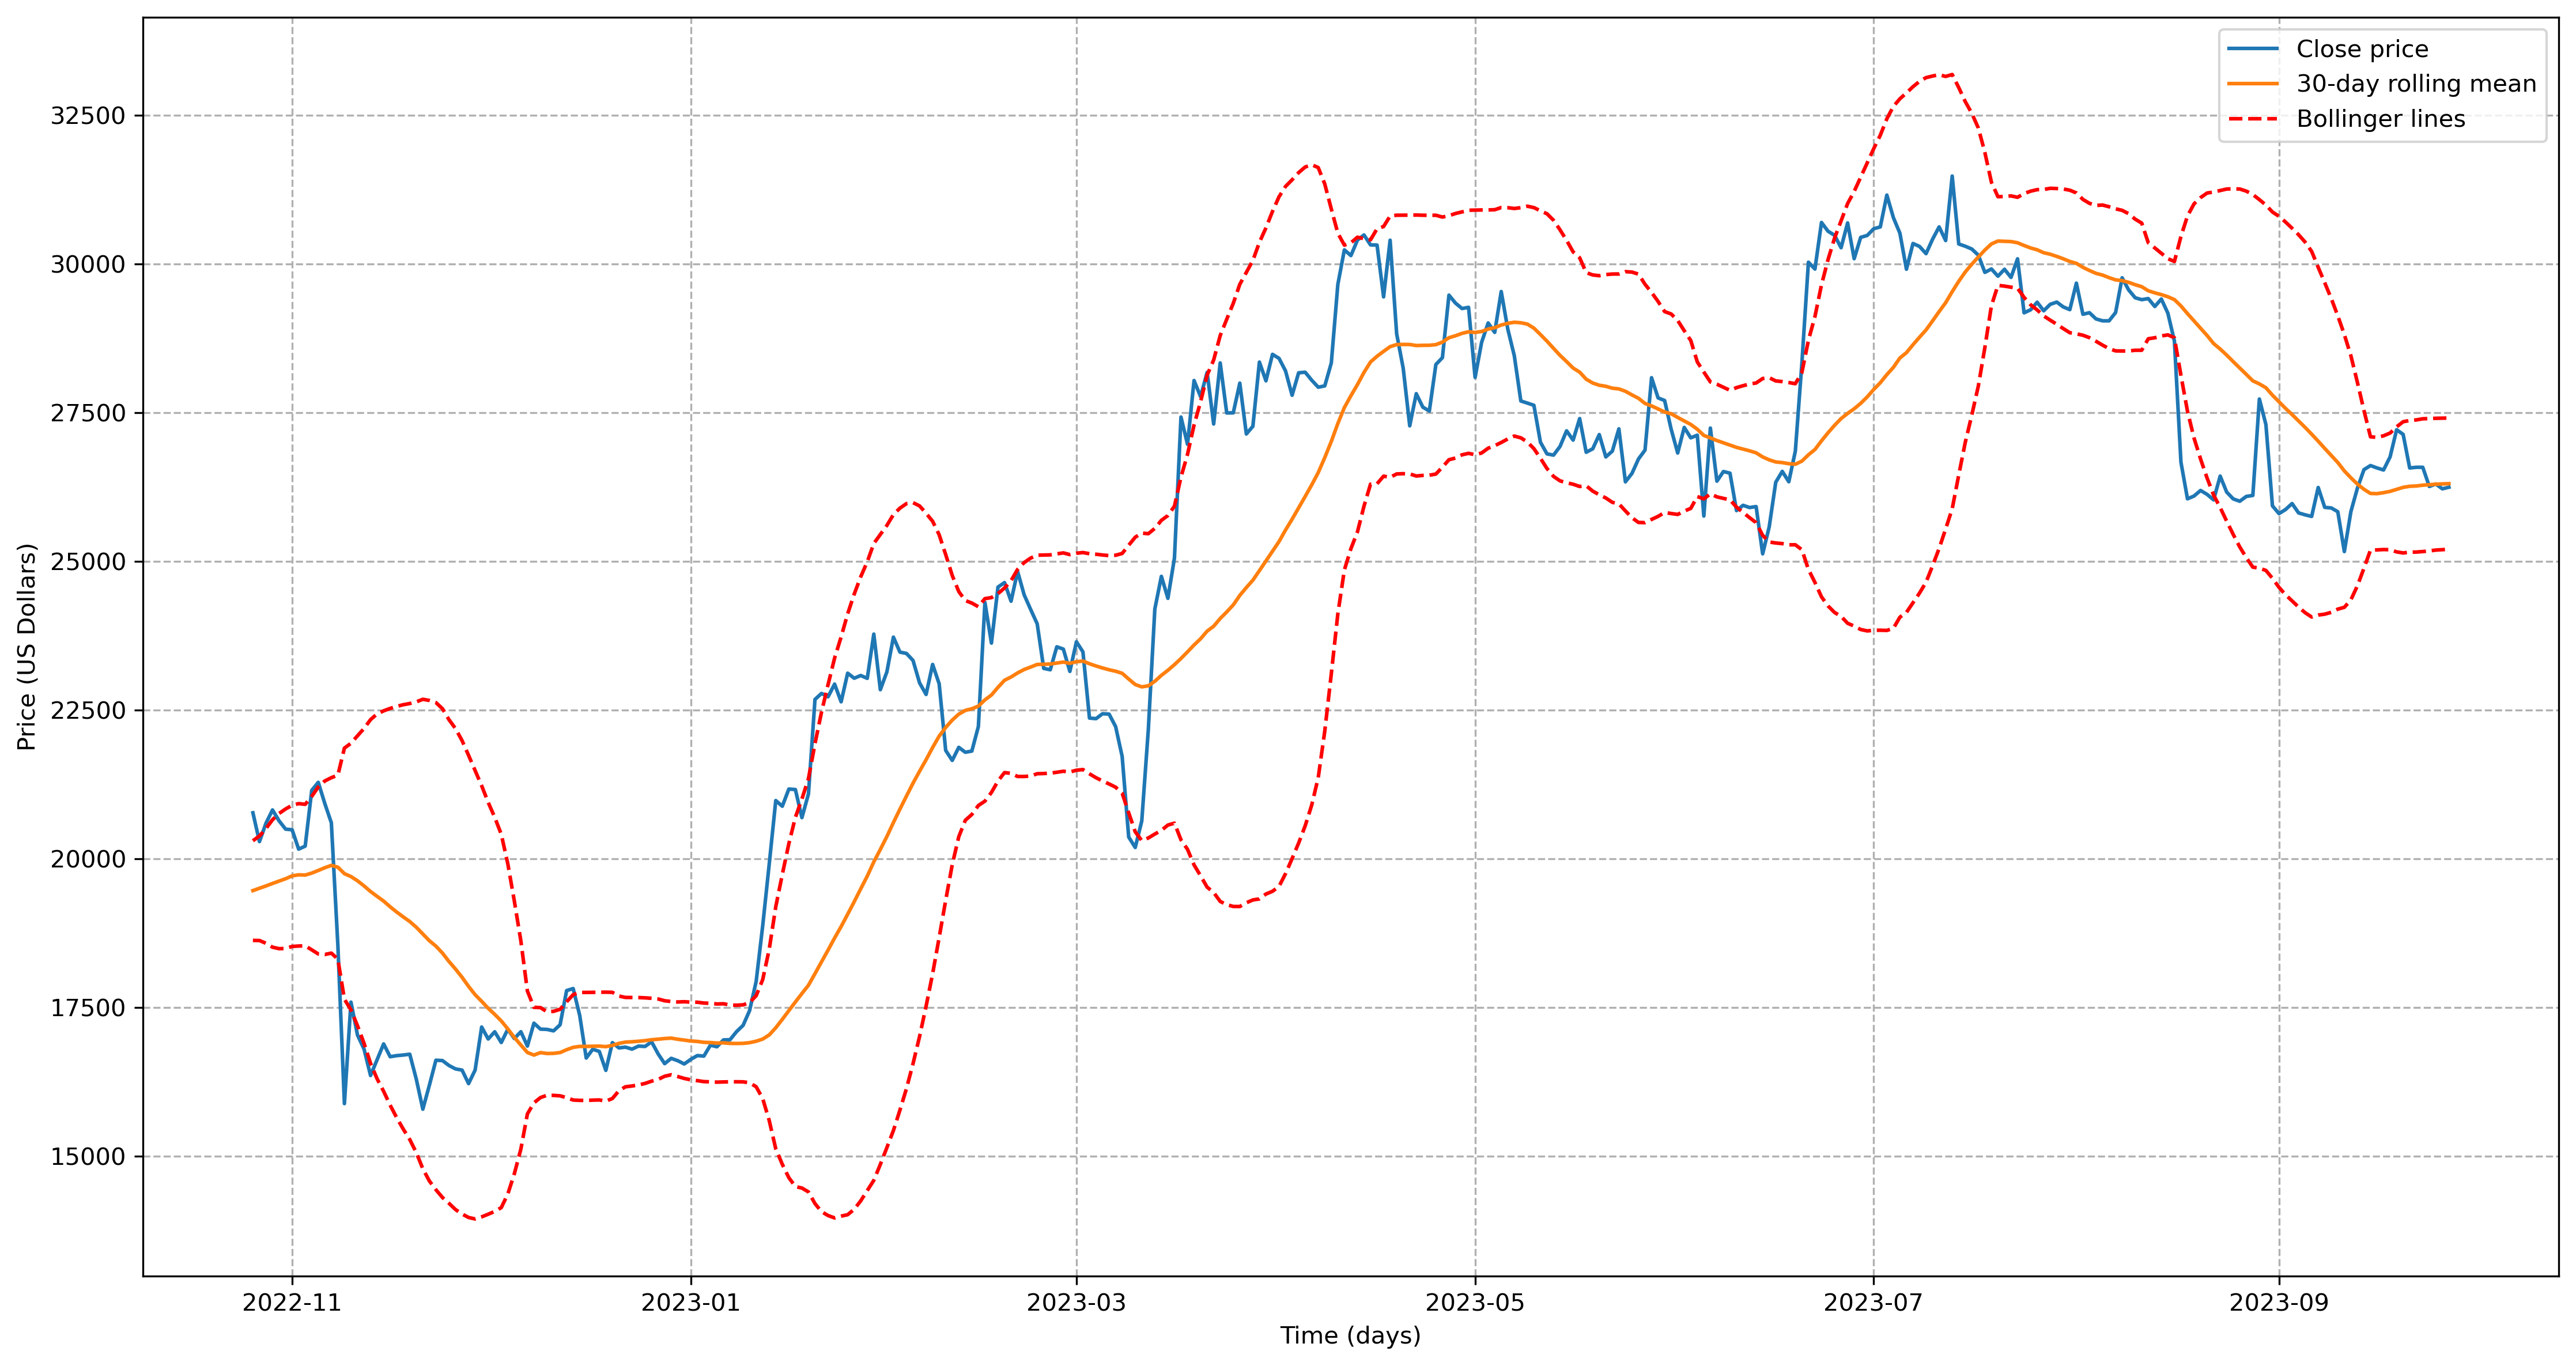

In [61]:
fig, ax = plt.subplots(figsize=[15,8])
ax.plot(close_bit["Close"], label="Close price")
ax.plot(close_bit["SMA30"], label="30-day rolling mean")
ax.plot(close_bit["Upper_Bollinger"], "r--", label="Bollinger lines")
ax.plot(close_bit["Lower_Bollinger"], "r--")

ax.set_xlabel("Time (days)")
ax.set_ylabel("Price (US Dollars)")
ax.grid(linestyle="dashed")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Este gráfico de líneas muestra la evolución de los precios de cierre de Bitcoin junto con su media móvil simple de 30 períodos y las bandas de Bollinger superior e inferior en el mismo subplot. Todo esto puede verse referenciado en la leyenda.

Como vemos en el gráfico,  las tres líneas aumentan y muestran que los precios de cierre de Bitcoin, la media móvil simple (SMA30), y las bandas de Bollinger superior e inferior. La evolución de los precios de "Close" de Bitcoin aumenta, como ya se ha dicho, esto significa que el valor de Bitcoin está experimentando un aumento en su precio de cierre en este período de tiempo.

La ventaja de tener presentes las líneas de Bollinger graficadas junto con el precio y la media móvil, es que nos permite realizar un rápido análisis temporal de la alta volatilidad del Bitcoin. De hecho, podemos ver los considerables aumentos de la volatilidad en los períodos de grandes cambios en el precio. Aunque la tendencia principal es alcista, la volatilidad de los precios es alta (sobre todo, si lo comparamos con el tradicional S&P500) lo que podría llevar a movimientos de precios más pronunciados en ambas direcciones.


### Correlación precio bitcoin vs S&P500

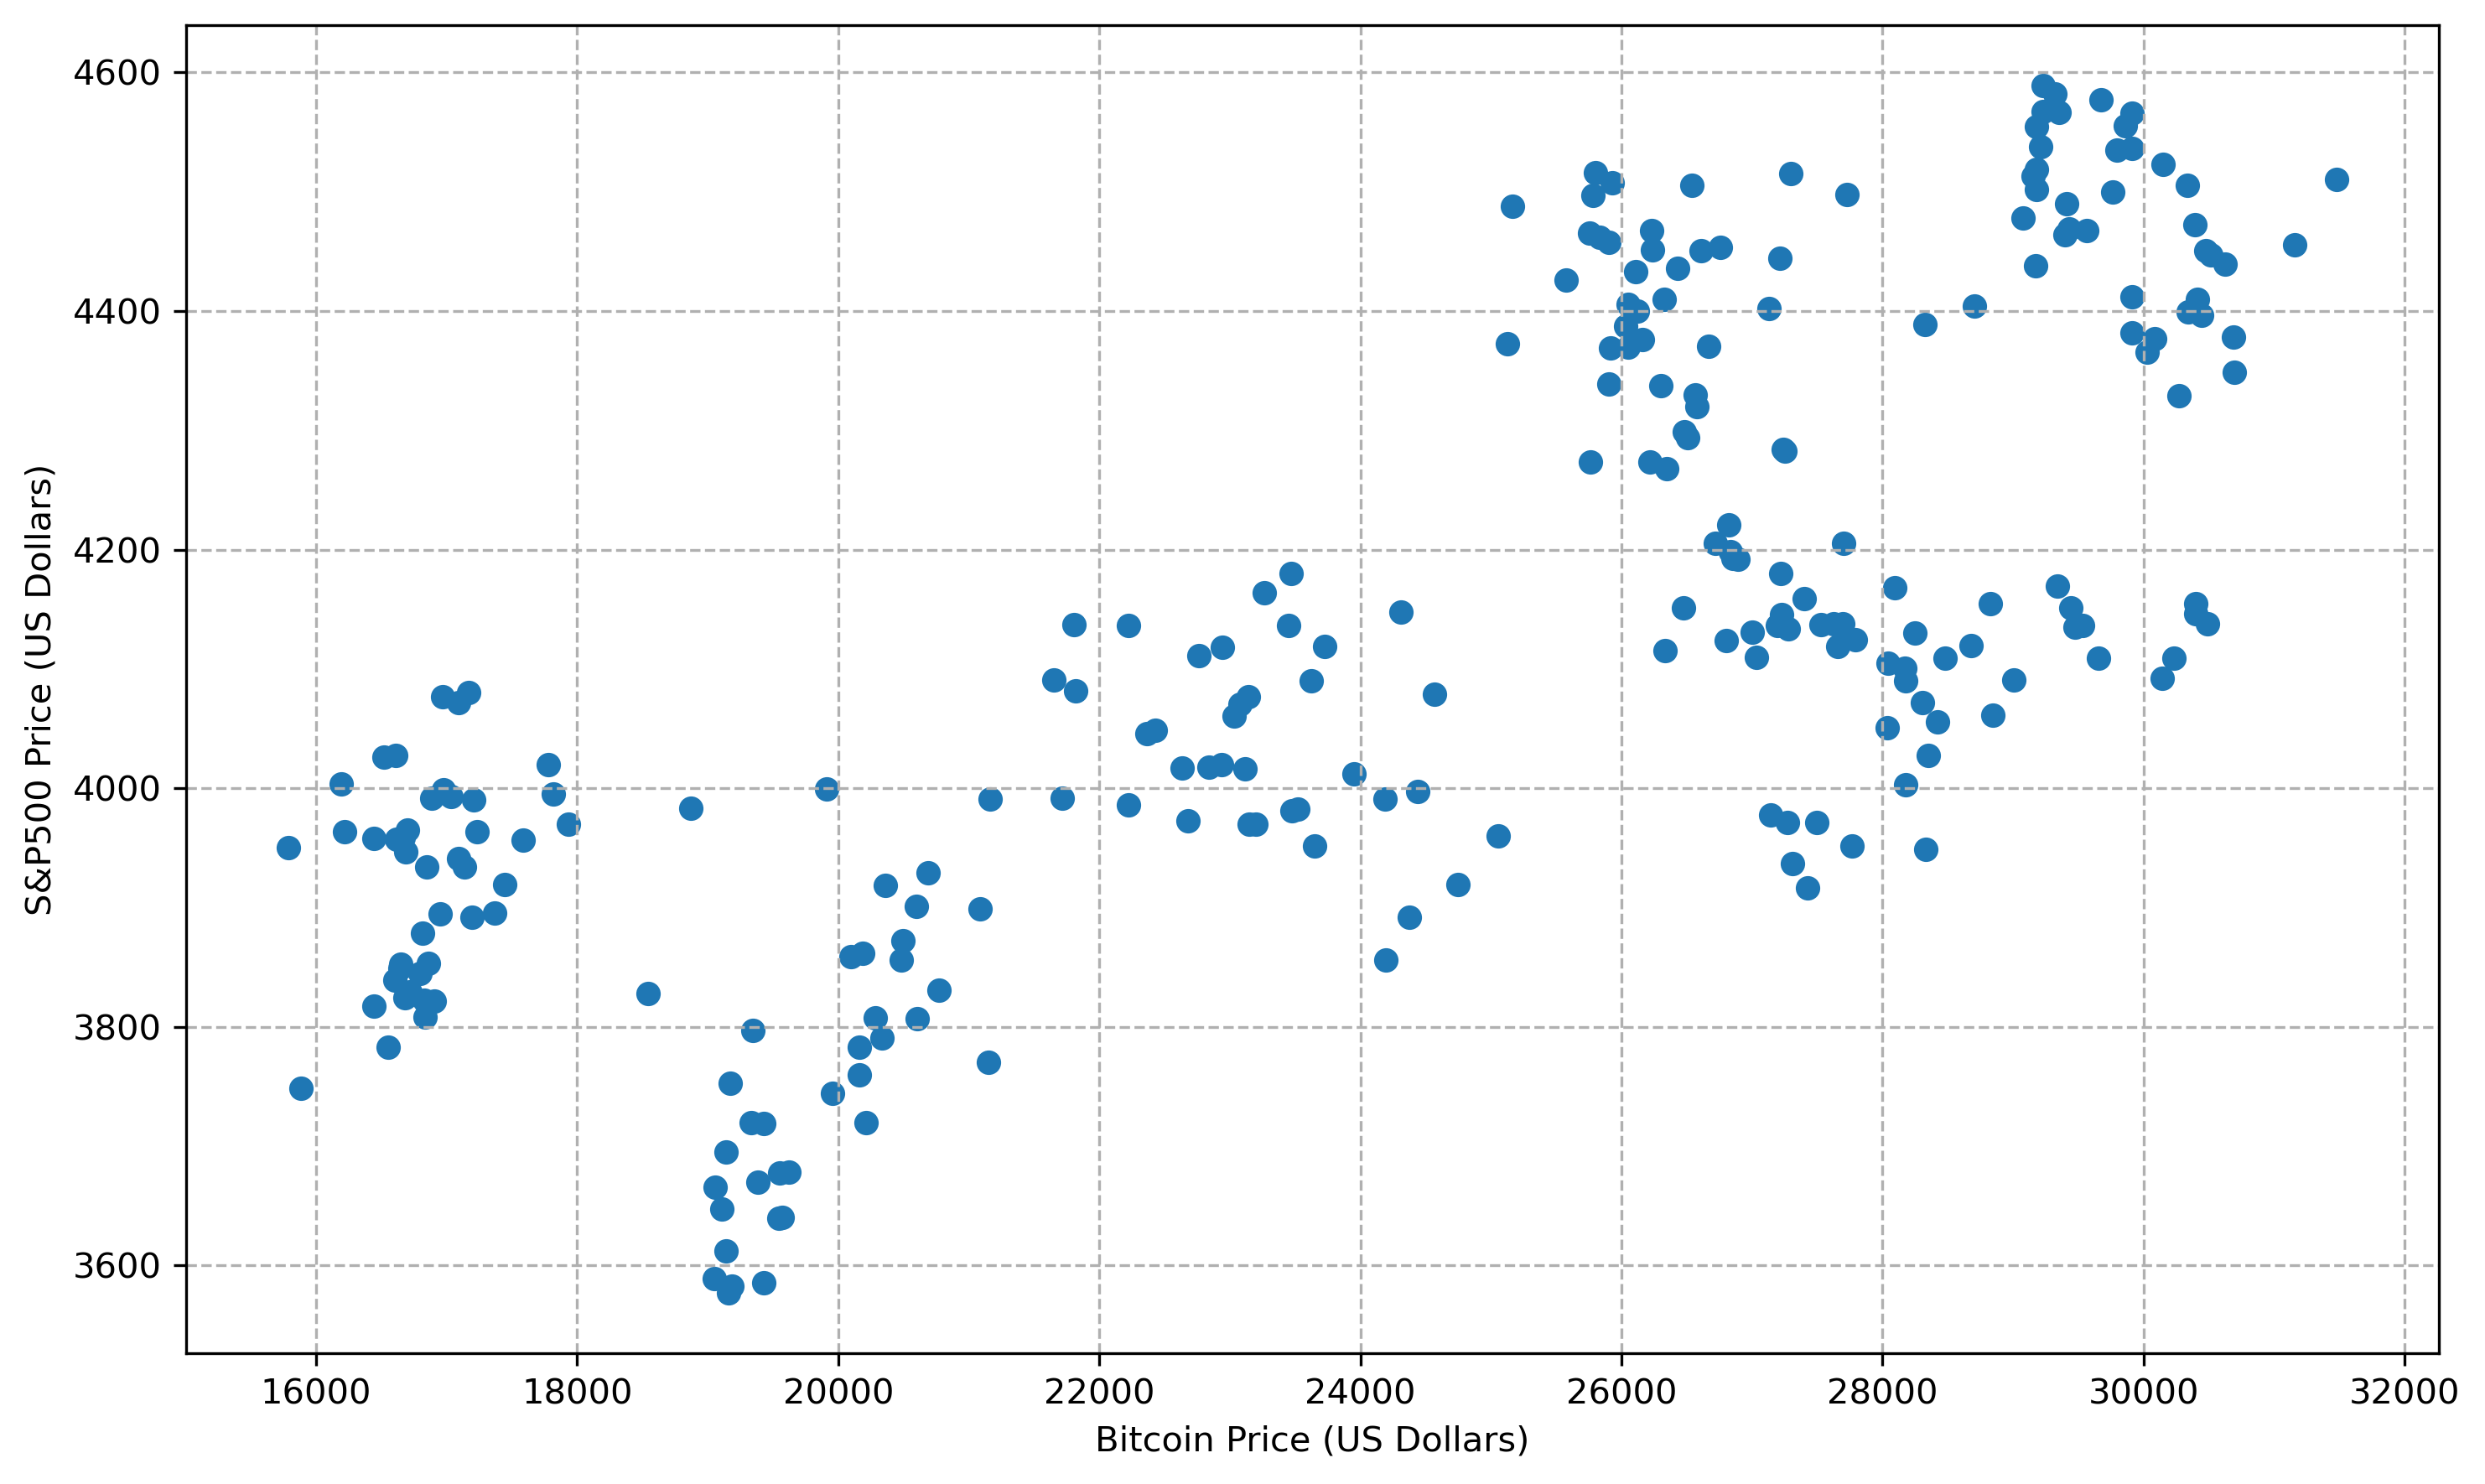

In [66]:
fig, ax = plt.subplots(figsize=[10,6])
ax.scatter(x=data3['Close_Bitcoin'], y=data3['Close_S&P_500'])
ax.set_xlabel("Bitcoin Price (US Dollars)")
ax.set_ylabel("S&P500 Price (US Dollars)")
ax.grid(linestyle="dashed")
plt.tight_layout()
plt.show()

En este scatterplot representa cada punto un par de valores: el precio de cierre de Bitcoin en el eje horizontal y el precio de cierre del S&P 500 en el eje vertical. Cada punto en el gráfico de dispersión representa una observación diaria de ambos conjuntos de datos.


Este scatterplot nos permite visualizar fácilmente si hay relación entre estas dos variables. En este caso, podrías analizar si existe alguna correlación o patrón entre los precios de cierre de Bitcoin y el S&P 500. Como vemos, los puntos tienden a agruparse hacia arriba y esto significa que hay una relación positiva entre los precios de cierre de Bitcoin y los precios de cierre del índice S&P 500.

En otras palabras, cuando los precios de cierre de Bitcoin tienden a aumentar, también tienden a aumentar los precios de cierre del S&P 500. Esto muestra que estos dos activos financieros o estas dos variables podrían estar relacionados de alguna manera o, simplemente, ambos cambian juntos debido a una causa subyacente. Lo más lógico es pensar que, un aumento en los índices económicos (representados habitualmente en EEUU por el S&P500) hace que se mejore la confianza en los mercados y la cantidad de líquido disponible por particulares y corporaciones para la inversión en general.


#### Otro ejemplo: 

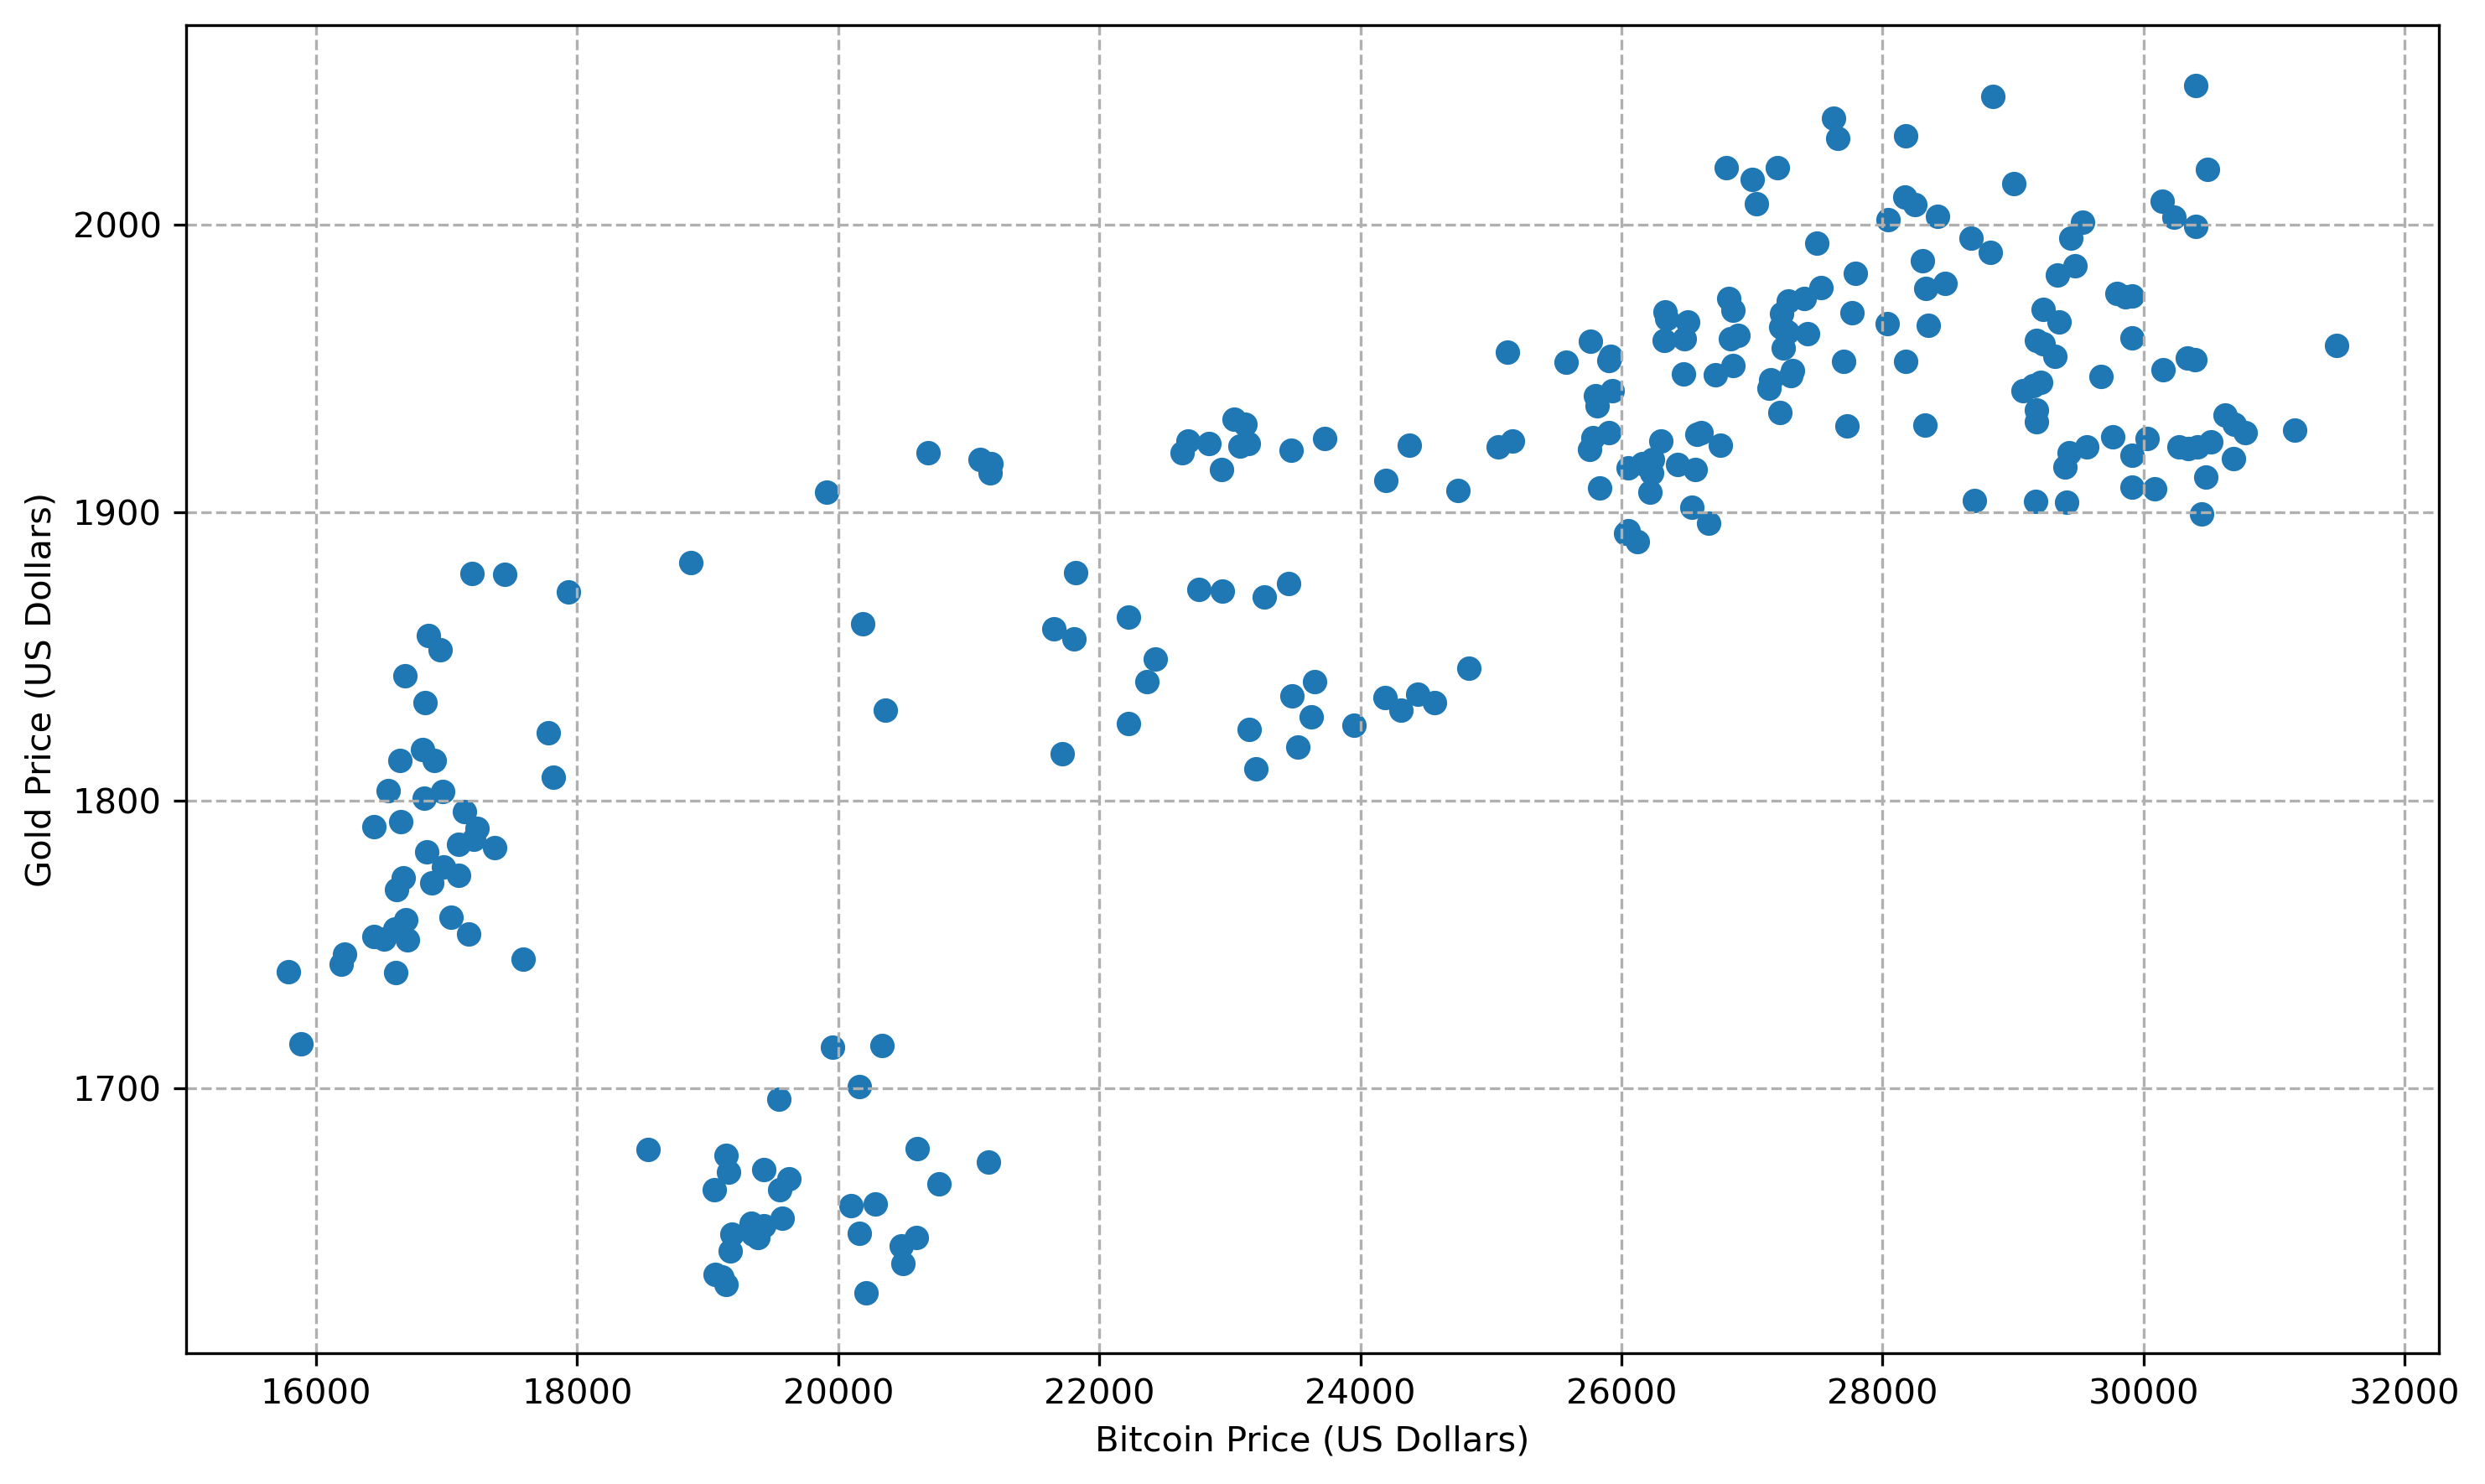

In [67]:
fig, ax = plt.subplots(figsize=[10,6])
plt.scatter(x=data3['Close_Bitcoin'], y=data3['USD (PM)'])
ax.set_xlabel("Bitcoin Price (US Dollars)")
ax.set_ylabel("Gold Price (US Dollars)")
ax.grid(linestyle="dashed")
plt.tight_layout()
plt.show()

Este scatter plot compara dos conjuntos de datos: 
- los precios de cierre de Bitcoin data3 'Close_Bitcoin' en el eje horizontal (eje x).
- Los precios del oro en dólares estadounidenses data3 'USD (PM)' en el eje vertical (eje y). 

Esto representa la relación entre los precios de cierre de Bitcoin y los precios del oro en dólares estadounidenses.

Cada punto en el gráfico representa una observación diaria de ambos conjuntos de datos. El gráfico nos permite visualizar si existe alguna relación aparente entre los precios de Bitcoin y los precios del oro y si hay alguna tendencia observable en los datos.

Como hemos visto en la anterior gráfica, vemos un aumento en nuestros datos, esto significa que existe una correlación positiva entre estas dos variables. En este contexto, un aumento general de los puntos indica que cuando los precios de cierre de Bitcoin aumentan, los precios del oro en dólares estadounidenses también tienden a aumentar. Esto sugiere que hay una relación positiva entre Bitcoin y el oro, lo que significa que, en promedio, cuando Bitcoin sube, el oro también tiende a subir.

### 5. Datos mediante gráficos

Aquí se representa el histograma de rentabilidad diaria. Definimos la rentabilidad diaria como 100 * Log2[Precio(t)/Precio (t-1]). 

In [73]:
daily_return = 100 * np.log2(hist_bitcoin['Close'] / hist_bitcoin['Close'].shift(1))

In [83]:
daily_return.dropna(inplace=True)

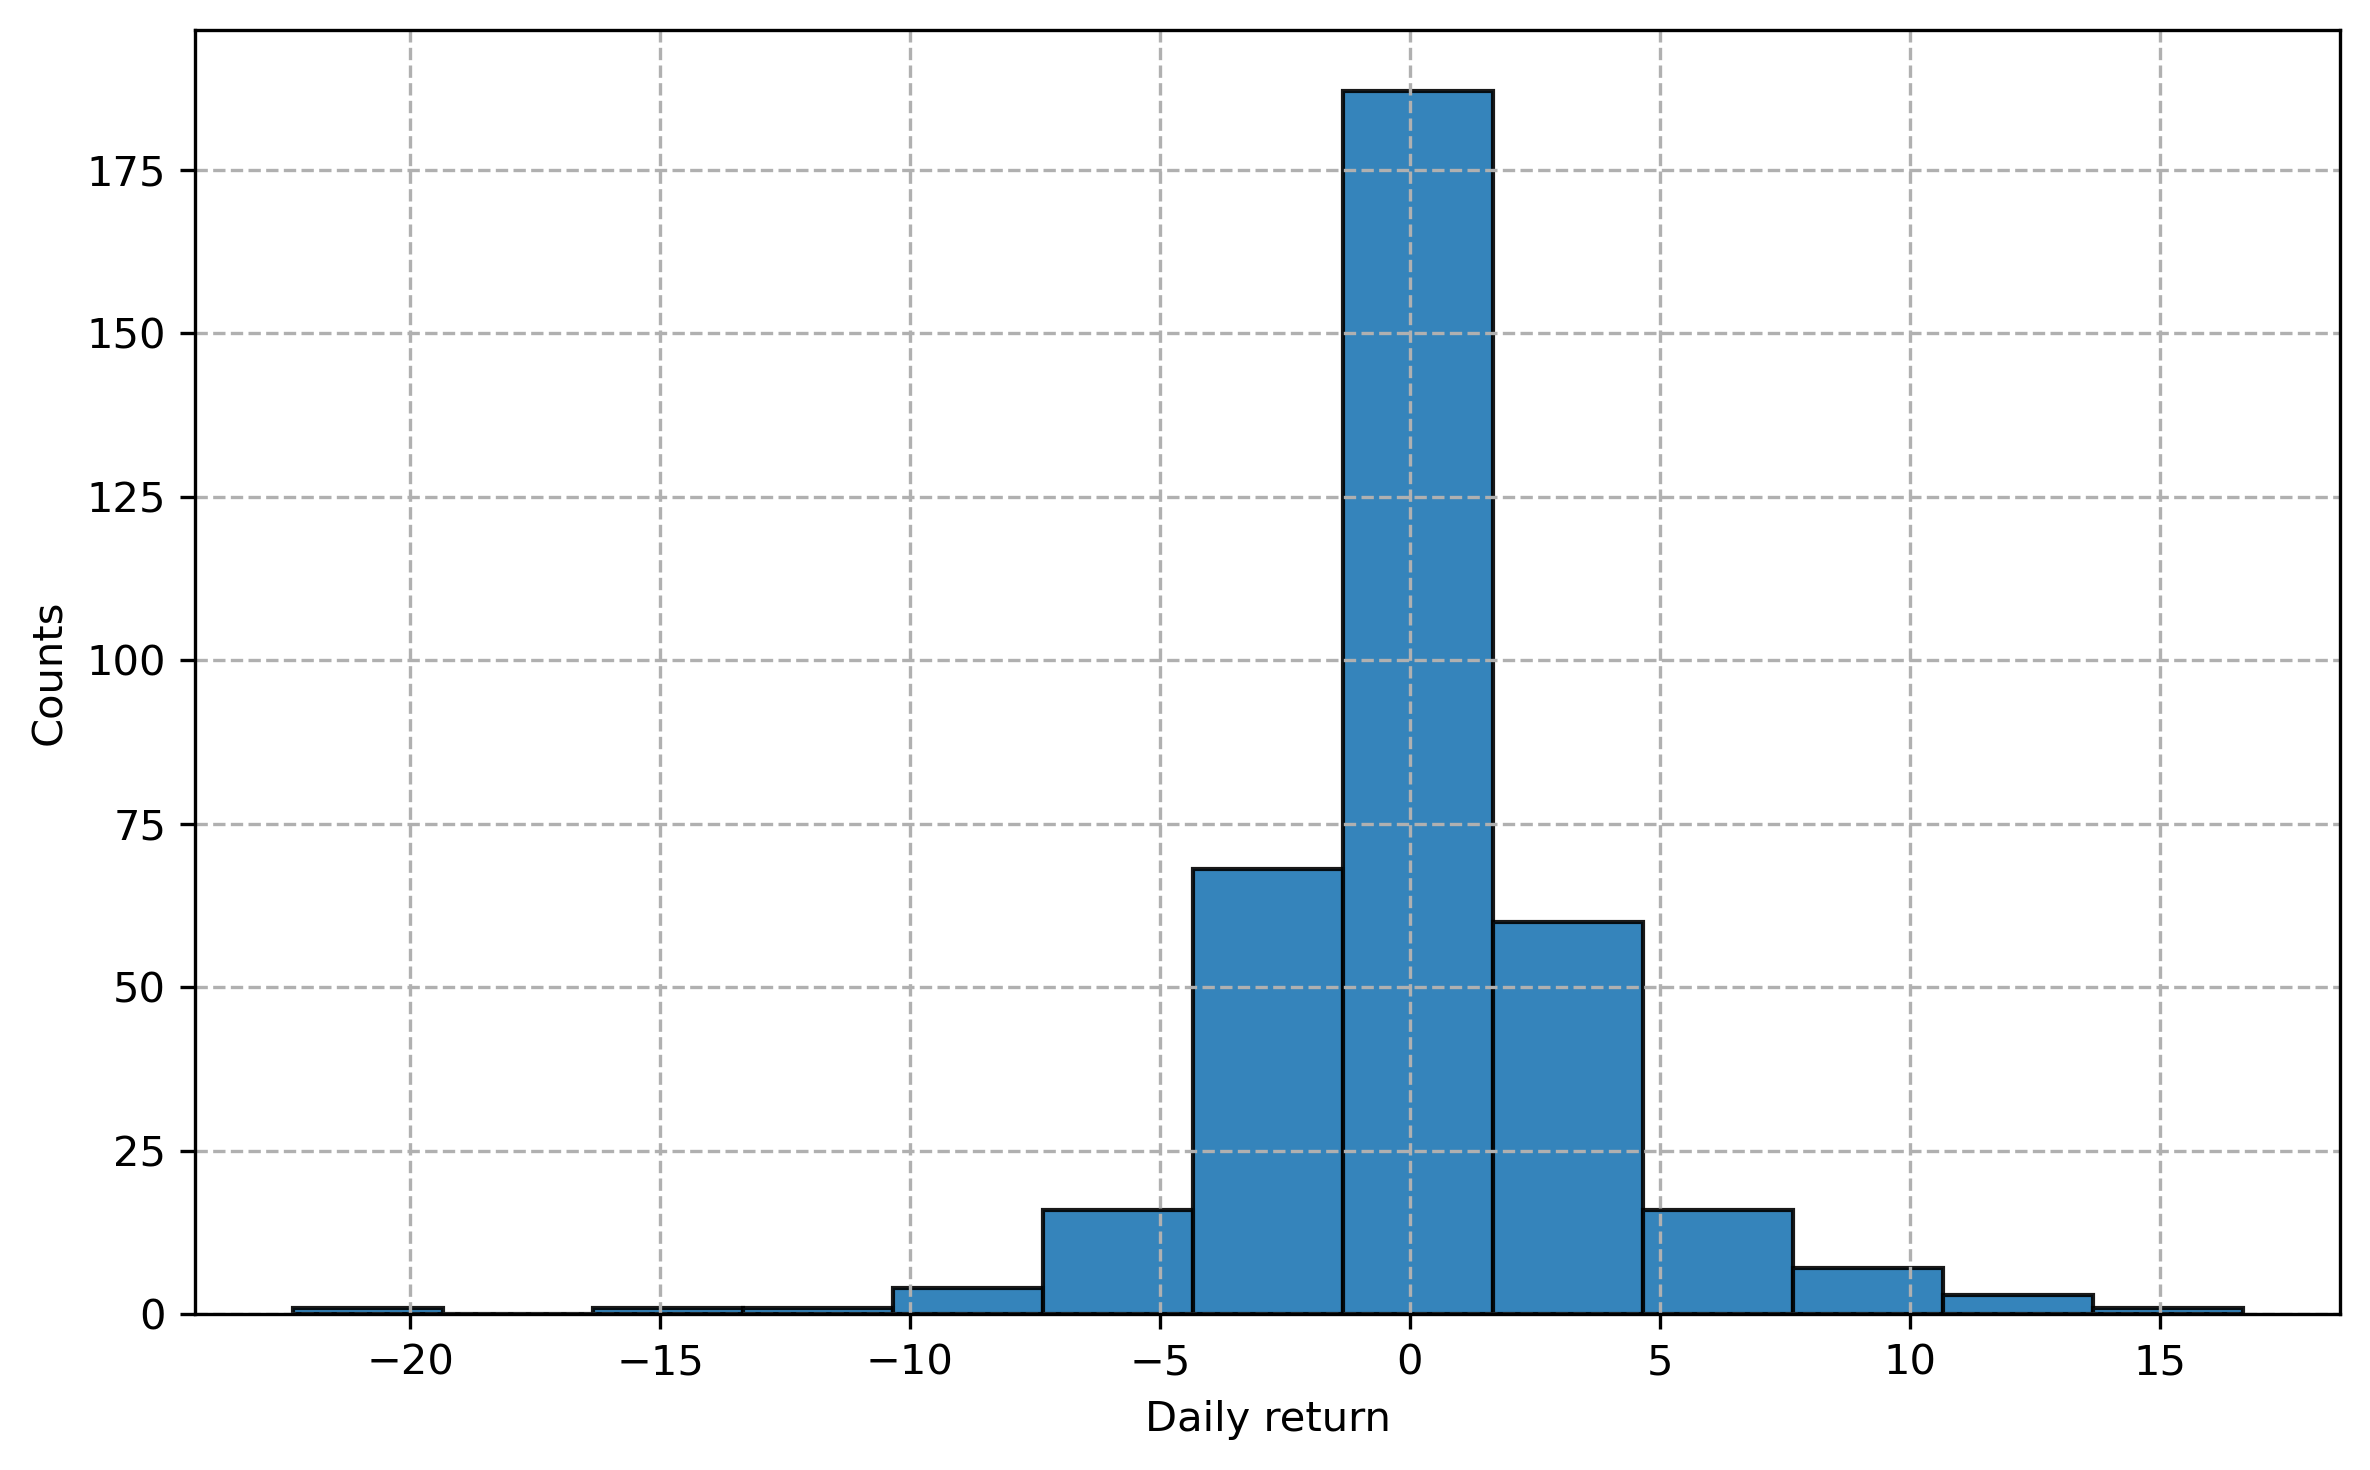

In [92]:
bin_width = 3
bin_edges = np.arange(daily_return.min(), daily_return.max() + bin_width, bin_width)

fig, ax = plt.subplots(figsize=[8,5])
ax.hist(daily_return, bins=bin_edges, edgecolor='k', alpha=0.9)
ax.set_xlabel("Daily return")
ax.set_ylabel("Counts")
ax.grid(linestyle="dashed")
plt.tight_layout()
plt.show()

Aquí estamos calculando los rendimientos diarios de una serie de datos y una transformación logarítmica.

Calculamos los rendimientos diarios de la serie de datos "Close_Bitcoin". Esto calcula el cambio porcentual entre un valor y el valor anterior en la serie, lo que representa el rendimiento diario.

El resultado de este histograma muestra la distribución de los rendimientos diarios de la serie "Close_Bitcoin con 12 bins. El eje x del histograma representa los rendimientos diarios, y el eje y muestra la frecuencia con la que se observan rendimientos en cada bin.

La parte positiva, indica los días que hay más rendimiento positivo. En otras palabras, los días muestran de crecimiento de ganancias en la inversión. Por otro lado, también podemos ver que existe una parte negativa, esto indica que hay días con rendimientos diarios negativos. En este caso, estos días días resultan en pérdidas en la inversión. En general, vemos la distribución bien centrada con respecto al cero, por lo que es posible que estos datos estén normalmente distribuidos. Un test de normalidad podría confirmar la sospecha:

In [94]:
statistic, p_value = stats.shapiro(daily_return)

print("Estadístico de prueba:", statistic)
print("Valor p:", p_value)

# Comprueba si se rechaza la hipótesis nula
alpha = 0.05
if p_value < alpha:
    print("Los datos no siguen una distribución normal (se rechaza H0)")
else:
    print("Los datos siguen una distribución normal (no se rechaza H0)")

Estadístico de prueba: 0.8894197940826416
Valor p: 1.4030238915243654e-15
Los datos no siguen una distribución normal (se rechaza H0)


De esta forma, se concluyen que estos datos en concreto no provienen de una distribución normal.

### 6. Generar nuevos datos a partir de otros datos/características ANTERIORES es habitual en finanzas

In [95]:
hist_bitcoin2 = hist_bitcoin.copy()
hist_bitcoin2.head()

Open          High           Low         Close  \
2022-09-27  19221.839844  20338.455078  18915.667969  19110.546875   
2022-09-28  19104.621094  19688.343750  18553.296875  19426.720703   
2022-09-29  19427.779297  19589.265625  18924.353516  19573.050781   
2022-09-30  19573.431641  20109.849609  19265.662109  19431.789062   
2022-10-01  19431.105469  19471.154297  19231.082031  19312.095703   

                 Volume  
2022-09-27  58571439619  
2022-09-28  53071298734  
2022-09-29  41037843771  
2022-09-30  43975248085  
2022-10-01  18719537670

Este es el resultado de dos DataFrames **hist_bitcoin** y **hist_bitcoin2** y estos contienen los mismos datos de precios de Bitcoin.

In [96]:
# Price amplitude
hist_bitcoin2['price_amplitude'] = 100 * ((hist_bitcoin2['High'] / hist_bitcoin2['Low']) - 1)

# 7-day-return
hist_bitcoin2['7-day-return'] = 100 * (np.log2(hist_bitcoin2['Close'] / hist_bitcoin2['Close'].shift(7)))

# Simple moving average (SMA) of 7 and 14 days:
hist_bitcoin2['SMA_7'] = hist_bitcoin2['Close'].rolling(window=7).mean()
hist_bitcoin2['SMA_14'] = hist_bitcoin2['Close'].rolling(window=14).mean()

# Moving average crossover
hist_bitcoin2['SMA_CROSS'] = 0
hist_bitcoin2.loc[hist_bitcoin2["SMA_7"]>hist_bitcoin2["SMA_14"], "SMA_CROSS"] = 1

In [98]:
hist_bitcoin2.dropna(inplace=True)

In [99]:
hist_bitcoin2.head()

Open          High           Low         Close  \
2022-10-10  19446.416016  19515.466797  19102.978516  19141.484375   
2022-10-11  19139.000000  19241.960938  18925.603516  19051.417969   
2022-10-12  19052.646484  19203.199219  19029.757812  19157.445312   
2022-10-13  19156.966797  19453.328125  18319.822266  19382.904297   
2022-10-14  19382.533203  19889.146484  19115.408203  19185.656250   

                 Volume  price_amplitude  7-day-return         SMA_7  \
2022-10-10  27425022774         2.159288     -3.588556  19714.904576   
2022-10-11  28711532910         1.671584     -9.419741  19531.272321   
2022-10-12  24950173846         0.911422     -7.364175  19387.947824   
2022-10-13  44219840004         6.187319     -4.199757  19306.156529   
2022-10-14  38452356727         4.047720     -2.690799  19254.557478   

                  SMA_14  SMA_CROSS  
2022-10-10  19537.587333          1  
2022-10-11  19533.363839          0  
2022-10-12  19514.129883          0  
2022-10-13  19500.547991          0  
2022-10-14  19482.967076          0

In [100]:
hist_bitcoin2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 353 entries, 2022-10-10 to 2023-09-27
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             353 non-null    float64
 1   High             353 non-null    float64
 2   Low              353 non-null    float64
 3   Close            353 non-null    float64
 4   Volume           353 non-null    int64  
 5   price_amplitude  353 non-null    float64
 6   7-day-return     353 non-null    float64
 7   SMA_7            353 non-null    float64
 8   SMA_14           353 non-null    float64
 9   SMA_CROSS        353 non-null    int64  
dtypes: float64(8), int64(2)
memory usage: 30.3+ KB


El resultado de este DataFrame contiene buena información para analizar la evolución de los precios de Bitcoin y las señales generadas por las medias móviles, lo que puede ayudar en la toma de decisiones en el mercado de criptomonedas.

La columna de "price_amplitude" representa  la amplitud de precios en porcentaje. Se calcula como la diferencia porcentual entre el precio máximo (High) y el precio mínimo (Low) en un período de tiempo específico. 

Como podemos ver, muestra el retorno de 7 días en porcentaje. Representa cuánto ha cambiado el precio de cierre (Close) en los últimos 7 días en relación con el precio de cierre de hace 7 días. 

También hemos hecho un estudio con SMA_7, dónde se encuentra la media móvil simple de 7 días, es el promedio de los precios de cierre de los últimos 7 días y se utiliza para suavizar las fluctuaciones en los precios a corto plazo. Lo mismo con la columna SMA_14, pero calculada para un período de 14 días, esto es útil para observar tendencias a medio plazo.


<img src="https://d32ijn7u0aqfv4.cloudfront.net/wp/wp-content/uploads/raw/SOIN21140_1560x880.jpg" width="500"/>